Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def check_correct_md(df_):
        def is_md_correct(row, md, md_last):
            difference = row[md_last] - row[md]
            if (difference - 0.2) > 0.001:
                display(row)
            return row

        copy_df_ = df_.copy()
        copy_df_['MD_last'] = copy_df_['MD'].shift(-1)
        copy_df_.apply(
            lambda row: is_md_correct(row, 'MD', 'MD_last'), axis=1)
        del copy_df_['MD_last']

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    check_correct_md(df.copy())
    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    return feature


name_dataset = 'DATATRAIN18+LAYER.csv'  # 'DATATRAINSHORTSTANDLAY.csv'
wells_base_df = get_for_learn_clean_df(pd.read_csv(name_dataset, sep=';'))
display(wells_base_df.describe())
wells_samples_df = get_well_dfs(wells_base_df)
wells_add_detrends_df = add_wells_features(wells_samples_df, ['SP', 'GR', 'BK', 'NKTB'])

MD            BK        Facies            GR           LIT  \
count  81906.000000  78294.000000  81906.000000  81906.000000  81906.000000   
mean    2137.625527  -2510.093415  -9666.529461     10.702307  -8059.370889   
std      397.628930   4354.708474   1793.207271      6.943744   3954.292496   
min      707.000000  -9999.000000  -9999.000000      0.680000  -9999.000000   
25%     1877.800000  -9999.000000  -9999.000000      7.840000  -9999.000000   
50%     2159.600000      5.840000  -9999.000000      9.778500  -9999.000000   
75%     2433.600000      8.509500  -9999.000000     12.112000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP  
count  81906.000000  81906.000000  
mean       3.607056    106.134190  
std        0.907451     38.822690  
min        0.970000     -1.588982  
25%        3.037409     81.430000  
50%        3.580072    104.451000  
75%        4.066400    122.000000  
max       15.351170    578.255500

In [3]:
def get_well_with_distance_features(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 20, 25]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()
    
    prefix = '_detrend'

    well_copy['GR_rooling_max_15'] = well_copy['GR'].rolling(window=15 * 5, center=True).max()
    well_copy['GR_rooling_min_15'] = well_copy['GR'].rolling(window=15 * 5, center=True).min()
    well_copy['GR_rooling_mean_15'] = well_copy['GR'].rolling(window=15 * 5, center=True).mean()
    
    well_copy['GR_rooling_max_20'] = well_copy['GR'].rolling(window=20 * 5, center=True).max()
    well_copy['GR_rooling_min_20'] = well_copy['GR'].rolling(window=20 * 5, center=True).min()
    well_copy['GR_rooling_mean_20'] = well_copy['GR'].rolling(window=20 * 5, center=True).mean()
    
    well_copy['GR_rooling_max_5'] = well_copy['GR'].rolling(window=5 * 5, center=True).max()
    well_copy['GR_rooling_min_5'] = well_copy['GR'].rolling(window=5 * 5, center=True).min()
    well_copy['GR_rooling_mean_5'] = well_copy['GR'].rolling(window=5 * 5, center=True).mean()
    
    well_copy['GR_rooling_min_2'] = well_copy['GR'].rolling(window=2 * 5, center=True).min()
    well_copy['GR_rooling_max_2'] = well_copy['GR'].rolling(window=2 * 5, center=True).max()
    well_copy['GR_rooling_mean_2'] = well_copy['GR'].rolling(window=2 * 5, center=True).mean()

    well_copy['GR_rooling_min_3'] = well_copy['GR'].rolling(window=3 * 5, center=True).min()
    well_copy['GR_rooling_max_3'] = well_copy['GR'].rolling(window=3 * 5, center=True).max()
    well_copy['GR_rooling_mean_3'] = well_copy['GR'].rolling(window=3 * 5, center=True).mean()
    
    well_copy['GR_rooling_min_1'] = well_copy['GR'].rolling(window=1 * 5, center=True).min()
    well_copy['GR_rooling_max_1'] = well_copy['GR'].rolling(window=1 * 5, center=True).max()
    well_copy['GR_rooling_mean_1'] = well_copy['GR'].rolling(window=1 * 5, center=True).mean()
    
    
    well_copy['SP_rooling_max'] = well_copy['SP'].rolling(window=15 * 5, center=True).max()
    well_copy['SP_rooling_min'] = well_copy['SP'].rolling(window=15 * 5, center=True).min()
    well_copy['SP_rooling_mean'] = well_copy['SP'].rolling(window=15 * 5, center=True).mean()
    
    well_copy['SP_rooling_max_20'] = well_copy['SP'].rolling(window=20 * 5, center=True).max()
    well_copy['SP_rooling_min_20'] = well_copy['SP'].rolling(window=20 * 5, center=True).min()
    well_copy['SP_rooling_mean_20'] = well_copy['SP'].rolling(window=20 * 5, center=True).mean()
    
    well_copy['SP_rooling_min_5'] = well_copy['SP'].rolling(window=5 * 5, center=True).min()
    well_copy['SP_rooling_max_5'] = well_copy['SP'].rolling(window=5 * 5, center=True).max()
    well_copy['SP_rooling_mean_5'] = well_copy['SP'].rolling(window=5 * 5, center=True).mean()
    
    well_copy['SP_rooling_min_2'] = well_copy['SP'].rolling(window=2 * 5, center=True).min()
    well_copy['SP_rooling_max_2'] = well_copy['SP'].rolling(window=2 * 5, center=True).max()
    well_copy['SP_rooling_mean_2'] = well_copy['SP'].rolling(window=2 * 5, center=True).mean()

    well_copy['SP_rooling_min_3'] = well_copy['SP'].rolling(window=3 * 5, center=True).min()
    well_copy['SP_rooling_max_3'] = well_copy['SP'].rolling(window=3 * 5, center=True).max()
    well_copy['SP_rooling_mean_3'] = well_copy['SP'].rolling(window=3 * 5, center=True).mean()
    
    well_copy['SP_rooling_min_1'] = well_copy['SP'].rolling(window=1 * 5, center=True).min()
    well_copy['SP_rooling_max_1'] = well_copy['SP'].rolling(window=1 * 5, center=True).max()
    well_copy['SP_rooling_mean_1'] = well_copy['SP'].rolling(window=1 * 5, center=True).mean()
    
    
    well_copy['SP_rooling_detrend_max'] = well_copy['SP' + prefix].rolling(window=15 * 5, center=True).max()
    well_copy['SP_rooling_detrend_min'] = well_copy['SP' + prefix].rolling(window=15 * 5, center=True).min()
    well_copy['SP_rooling_detrend_mean'] = well_copy['SP' + prefix].rolling(window=15 * 5, center=True).mean()
    
    well_copy['SP_rooling_detrend_max_20'] = well_copy['SP' + prefix].rolling(window=20 * 5, center=True).max()
    well_copy['SP_rooling_detrend_min_20'] = well_copy['SP' + prefix].rolling(window=20 * 5, center=True).min()
    well_copy['SP_rooling_detrend_mean_20'] = well_copy['SP' + prefix].rolling(window=20 * 5, center=True).mean()
    
    well_copy['SP_rooling_detrend_min_5'] = well_copy['SP' + prefix].rolling(window=5 * 5, center=True).min()
    well_copy['SP_rooling_detrend_max_5'] = well_copy['SP' + prefix].rolling(window=5 * 5, center=True).max()
    well_copy['SP_rooling_detrend_mean_5'] = well_copy['SP' + prefix].rolling(window=5 * 5, center=True).mean()
    
    well_copy['SP_rooling_detrend_min_2'] = well_copy['SP' + prefix].rolling(window=2 * 5, center=True).min()
    well_copy['SP_rooling_detrend_max_2'] = well_copy['SP' + prefix].rolling(window=2 * 5, center=True).max()
    well_copy['SP_rooling_prefix_mean_2'] = well_copy['SP' + prefix].rolling(window=2 * 5, center=True).mean()

    well_copy['SP_rooling_detrend_min_3'] = well_copy['SP' + prefix].rolling(window=3 * 5, center=True).min()
    well_copy['SP_rooling_detrend_max_3'] = well_copy['SP' + prefix].rolling(window=3 * 5, center=True).max()
    well_copy['SP_rooling_detrend_mean_3'] = well_copy['SP' + prefix].rolling(window=3 * 5, center=True).mean()
    
    well_copy['SP_rooling_detrend_min_1'] = well_copy['SP' + prefix].rolling(window=1 * 5, center=True).min()
    well_copy['SP_rooling_detrend_max_1'] = well_copy['SP' + prefix].rolling(window=1 * 5, center=True).max()
    well_copy['SP_rooling_detrend_mean_1'] = well_copy['SP' + prefix].rolling(window=1 * 5, center=True).mean()
    
    #well_copy['BK_rooling_max_1'] = well_copy['BK'].rolling(window=1 * 5, center=True).max()
    #well_copy['BK_rooling_max_2'] = well_copy['BK'].rolling(window=2 * 5, center=True).max()
    #well_copy['BK_rooling_max_3'] = well_copy['BK'].rolling(window=3 * 5, center=True).max()
    #well_copy['BK_rooling_max_5'] = well_copy['BK'].rolling(window=5 * 5, center=True).max()
    #well_copy['BK_rooling_max_8'] = well_copy['BK'].rolling(window=8 * 5, center=True).max()
    #well_copy['BK_rooling_max_12'] = well_copy['BK'].rolling(window=12 * 5, center=True).max()
    #well_copy['BK_rooling_max_15'] = well_copy['BK'].rolling(window=15 * 5, center=True).max()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR' + prefix)
        add_feature_last(well_copy, shift, 'SP' + prefix)
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR' + prefix)
        add_feature_next(well_copy, shift, 'SP' + prefix)
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    #well_copy['GR'] = well_copy['GR' + prefix]
    #well_copy['SP'] = well_copy['SP' + prefix]
    
    #del well_copy['BK']
    #del well_copy['NKTB']
    
    #del well_copy['GR']
    #del well_copy['SP']

    #del well_copy['GR' + prefix]
    #del well_copy['SP' + prefix]
    del well_copy['BK' + prefix]
    del well_copy['NKTB' + prefix]

    return well_copy


def get_well_with_features_df(wells):
    wells_return = []
    for well in wells:
        well_with_new_features = get_well_with_distance_features(well)
        print(well_with_new_features)
        wells_return.append(well_with_new_features)
    return wells_return


well_with_features = get_well_with_features_df(wells_add_detrends_df)
for_ml_preprocessing = pd.concat(well_with_features)


     wellName datasetName      MD    BK  Facies     GR  LAYER   LIT      NKTB  \
0     spk1521   TrainLogs  2011.0  4.42   -9999  13.60  -9999 -9999  2.968678   
1     spk1521   TrainLogs  2011.2  4.30   -9999  13.51  -9999 -9999  2.937724   
2     spk1521   TrainLogs  2011.4  4.31   -9999  13.17  -9999 -9999  2.973814   
3     spk1521   TrainLogs  2011.6  4.28   -9999  13.03  -9999 -9999  2.989185   
4     spk1521   TrainLogs  2011.8  4.26   -9999  12.94  -9999 -9999  2.968678   
5     spk1521   TrainLogs  2012.0  4.41   -9999  12.64  -9999 -9999  3.024832   
6     spk1521   TrainLogs  2012.2  4.50   -9999  12.61  -9999 -9999  3.055148   
7     spk1521   TrainLogs  2012.4  5.00   -9999  12.93  -9999 -9999  3.105200   
8     spk1521   TrainLogs  2012.6  4.75   -9999  13.44  -9999 -9999  3.139893   
9     spk1521   TrainLogs  2012.8  4.59   -9999  13.41  -9999 -9999  3.115140   
10    spk1521   TrainLogs  2013.0  4.63   -9999  13.23  -9999 -9999  3.134954   
11    spk1521   TrainLogs  2

      wellName datasetName      MD     BK  Facies    GR  LAYER   LIT  NKTB  \
14277  spk1527   TrainLogs  1773.2   3.86   -9999  5.13  -9999 -9999  2.94   
14278  spk1527   TrainLogs  1773.4   3.83   -9999  5.26  -9999 -9999  2.93   
14279  spk1527   TrainLogs  1773.6   3.82   -9999  5.40  -9999 -9999  3.05   
14280  spk1527   TrainLogs  1773.8   3.90   -9999  5.50  -9999 -9999  3.08   
14281  spk1527   TrainLogs  1774.0   4.05   -9999  5.70  -9999 -9999  3.12   
14282  spk1527   TrainLogs  1774.2   4.03   -9999  5.95  -9999 -9999  3.07   
14283  spk1527   TrainLogs  1774.4   3.94   -9999  5.97  -9999 -9999  2.92   
14284  spk1527   TrainLogs  1774.6   3.92   -9999  5.50  -9999 -9999  2.83   
14285  spk1527   TrainLogs  1774.8   3.83   -9999  5.10  -9999 -9999  2.93   
14286  spk1527   TrainLogs  1775.0   3.83   -9999  4.99  -9999 -9999  3.03   
14287  spk1527   TrainLogs  1775.2   3.87   -9999  5.00  -9999 -9999  2.86   
14288  spk1527   TrainLogs  1775.4   4.10   -9999  5.24  -9999 -

      wellName datasetName      MD     BK  Facies     GR  LAYER  LIT  NKTB  \
27539  spk1769   TrainLogs  1655.0   5.41   -9999   6.03  -9999    4  2.16   
27540  spk1769   TrainLogs  1655.2   5.05   -9999   5.77  -9999    4  2.04   
27541  spk1769   TrainLogs  1655.4   5.28   -9999   5.76  -9999    4  2.07   
27542  spk1769   TrainLogs  1655.6   4.89   -9999   5.60  -9999    4  2.21   
27543  spk1769   TrainLogs  1655.8   4.61   -9999   4.95  -9999    4  2.05   
27544  spk1769   TrainLogs  1656.0   4.20   -9999   4.30  -9999    4  1.91   
27545  spk1769   TrainLogs  1656.2   5.01   -9999   4.10  -9999    4  2.23   
27546  spk1769   TrainLogs  1656.4   5.19   -9999   4.67  -9999    4  2.46   
27547  spk1769   TrainLogs  1656.6   5.18   -9999   5.57  -9999    4  2.41   
27548  spk1769   TrainLogs  1656.8   5.16   -9999   5.94  -9999    4  2.37   
27549  spk1769   TrainLogs  1657.0   5.19   -9999   5.86  -9999    4  2.36   
27550  spk1769   TrainLogs  1657.2   5.04   -9999   5.65  -9999 

      wellName datasetName      MD       BK  Facies    GR  LAYER   LIT  \
32685   spk400   TrainLogs  1644.0 -9999.00   -9999  7.24  -9999 -9999   
32687   spk400   TrainLogs  1644.2     7.66   -9999  7.60  -9999 -9999   
32689   spk400   TrainLogs  1644.4     7.73   -9999  7.26  -9999 -9999   
32691   spk400   TrainLogs  1644.6     7.73   -9999  7.26  -9999 -9999   
32693   spk400   TrainLogs  1644.8     7.82   -9999  7.19  -9999 -9999   
32695   spk400   TrainLogs  1645.0     7.73   -9999  7.14  -9999 -9999   
32697   spk400   TrainLogs  1645.2     7.82   -9999  6.80  -9999 -9999   
32699   spk400   TrainLogs  1645.4     7.82   -9999  6.86  -9999 -9999   
32701   spk400   TrainLogs  1645.6     7.88   -9999  6.36  -9999 -9999   
32703   spk400   TrainLogs  1645.8     7.73   -9999  6.24  -9999 -9999   
32705   spk400   TrainLogs  1646.0     7.82   -9999  7.46  -9999 -9999   
32707   spk400   TrainLogs  1646.2     7.82   -9999  7.93  -9999 -9999   
32709   spk400   TrainLogs  1646.4    

      wellName datasetName      MD     BK  Facies    GR  LAYER   LIT  NKTB  \
42066   spk402   TrainLogs  1640.0   7.12   -9999  5.98  -9999 -9999  2.14   
42067   spk402   TrainLogs  1640.2   6.55   -9999  5.99  -9999 -9999  2.15   
42068   spk402   TrainLogs  1640.4   6.48   -9999  5.94  -9999 -9999  2.17   
42069   spk402   TrainLogs  1640.6   6.55   -9999  5.70  -9999 -9999  2.19   
42070   spk402   TrainLogs  1640.8   6.80   -9999  5.58  -9999 -9999  2.20   
42071   spk402   TrainLogs  1641.0   6.99   -9999  5.73  -9999 -9999  2.22   
42072   spk402   TrainLogs  1641.2   6.99   -9999  5.84  -9999 -9999  2.26   
42073   spk402   TrainLogs  1641.4   7.12   -9999  6.08  -9999 -9999  2.23   
42074   spk402   TrainLogs  1641.6   7.67   -9999  5.41  -9999 -9999  2.14   
42075   spk402   TrainLogs  1641.8   7.05   -9999  4.92  -9999 -9999  2.04   
42076   spk402   TrainLogs  1642.0   6.14   -9999  4.97  -9999 -9999  1.95   
42077   spk402   TrainLogs  1642.2   5.97   -9999  5.06  -9999 -

      wellName datasetName      MD    BK  Facies     GR  LAYER   LIT  \
46677   spk403   TrainLogs  1640.0  10.0   -9999   7.91  -9999 -9999   
46678   spk403   TrainLogs  1640.2   9.9   -9999   8.10  -9999 -9999   
46679   spk403   TrainLogs  1640.4   9.7   -9999   8.12  -9999 -9999   
46680   spk403   TrainLogs  1640.6   9.6   -9999   7.95  -9999 -9999   
46681   spk403   TrainLogs  1640.8   9.6   -9999   7.63  -9999 -9999   
46682   spk403   TrainLogs  1641.0   9.6   -9999   7.68  -9999 -9999   
46683   spk403   TrainLogs  1641.2   9.6   -9999   7.82  -9999 -9999   
46684   spk403   TrainLogs  1641.4   9.2   -9999   7.72  -9999 -9999   
46685   spk403   TrainLogs  1641.6   9.1   -9999   7.41  -9999 -9999   
46686   spk403   TrainLogs  1641.8   9.1   -9999   7.86  -9999 -9999   
46687   spk403   TrainLogs  1642.0   9.1   -9999   8.15  -9999 -9999   
46688   spk403   TrainLogs  1642.2   9.1   -9999   8.05  -9999 -9999   
46689   spk403   TrainLogs  1642.4   9.0   -9999   8.10  -9999 -

      wellName datasetName      MD      BK  Facies    GR  LAYER   LIT    NKTB  \
51868  spk405R   TrainLogs  1640.0 -9999.0   -9999  10.4  -9999 -9999  2.4475   
51869  spk405R   TrainLogs  1640.2 -9999.0   -9999  10.4  -9999 -9999  2.5150   
51870  spk405R   TrainLogs  1640.4 -9999.0   -9999  10.4  -9999 -9999  2.4850   
51871  spk405R   TrainLogs  1640.6 -9999.0   -9999  10.4  -9999 -9999  2.5300   
51872  spk405R   TrainLogs  1640.8 -9999.0   -9999  10.1  -9999 -9999  2.6500   
51873  spk405R   TrainLogs  1641.0 -9999.0   -9999  10.8  -9999 -9999  2.8000   
51874  spk405R   TrainLogs  1641.2 -9999.0   -9999  11.9  -9999 -9999  2.7400   
51875  spk405R   TrainLogs  1641.4 -9999.0   -9999  11.5  -9999 -9999  2.7625   
51876  spk405R   TrainLogs  1641.6 -9999.0   -9999  11.2  -9999 -9999  2.7700   
51877  spk405R   TrainLogs  1641.8 -9999.0   -9999  10.8  -9999 -9999  2.7400   
51878  spk405R   TrainLogs  1642.0 -9999.0   -9999  10.8  -9999 -9999  2.8075   
51879  spk405R   TrainLogs  

      wellName datasetName      MD     BK  Facies    GR  LAYER   LIT  \
56844  spk406R   TrainLogs  1636.0    6.9   -9999  10.1  -9999 -9999   
56845  spk406R   TrainLogs  1636.2    7.2   -9999  10.6  -9999 -9999   
56846  spk406R   TrainLogs  1636.4    7.8   -9999  10.8  -9999 -9999   
56847  spk406R   TrainLogs  1636.6    8.5   -9999  11.1  -9999 -9999   
56848  spk406R   TrainLogs  1636.8    8.9   -9999  10.7  -9999 -9999   
56849  spk406R   TrainLogs  1637.0    9.1   -9999  10.5  -9999 -9999   
56850  spk406R   TrainLogs  1637.2    9.1   -9999  10.4  -9999 -9999   
56851  spk406R   TrainLogs  1637.4    9.4   -9999  10.0  -9999 -9999   
56852  spk406R   TrainLogs  1637.6   10.1   -9999   9.9  -9999 -9999   
56853  spk406R   TrainLogs  1637.8   10.9   -9999  10.2  -9999 -9999   
56854  spk406R   TrainLogs  1638.0   11.8   -9999  10.2  -9999 -9999   
56855  spk406R   TrainLogs  1638.2   17.4   -9999   9.7  -9999 -9999   
56856  spk406R   TrainLogs  1638.4   31.9   -9999   9.2  -9999 -

      wellName datasetName      MD     BK  Facies     GR  LAYER   LIT  \
62050  spk409R   TrainLogs  1660.0    5.9   -9999   7.44  -9999 -9999   
62051  spk409R   TrainLogs  1660.2    5.6   -9999   7.44  -9999 -9999   
62052  spk409R   TrainLogs  1660.4    5.6   -9999   6.92  -9999 -9999   
62053  spk409R   TrainLogs  1660.6    6.1   -9999   7.44  -9999 -9999   
62054  spk409R   TrainLogs  1660.8    6.4   -9999   7.04  -9999 -9999   
62055  spk409R   TrainLogs  1661.0    6.7   -9999   7.20  -9999 -9999   
62056  spk409R   TrainLogs  1661.2    6.2   -9999   7.44  -9999 -9999   
62057  spk409R   TrainLogs  1661.4    7.0   -9999   7.28  -9999 -9999   
62058  spk409R   TrainLogs  1661.6    6.1   -9999   7.04  -9999 -9999   
62059  spk409R   TrainLogs  1661.8    5.5   -9999   7.24  -9999 -9999   
62060  spk409R   TrainLogs  1662.0    5.2   -9999   7.76  -9999 -9999   
62061  spk409R   TrainLogs  1662.2    5.9   -9999   7.92  -9999 -9999   
62062  spk409R   TrainLogs  1662.4    7.2   -9999  

      wellName datasetName      MD     BK  Facies     GR  LAYER   LIT  \
66996  spk420R   TrainLogs  1665.0   8.42   -9999   9.28  -9999 -9999   
66997  spk420R   TrainLogs  1665.2   8.89   -9999   9.23  -9999 -9999   
66998  spk420R   TrainLogs  1665.4   8.07   -9999   9.33  -9999 -9999   
66999  spk420R   TrainLogs  1665.6   7.49   -9999   9.62  -9999 -9999   
67000  spk420R   TrainLogs  1665.8   7.96   -9999   9.72  -9999 -9999   
67001  spk420R   TrainLogs  1666.0   8.07   -9999   9.61  -9999 -9999   
67002  spk420R   TrainLogs  1666.2   8.19   -9999   9.00  -9999 -9999   
67003  spk420R   TrainLogs  1666.4   8.30   -9999   9.40  -9999 -9999   
67004  spk420R   TrainLogs  1666.6   8.19   -9999   9.14  -9999 -9999   
67005  spk420R   TrainLogs  1666.8   8.30   -9999   8.65  -9999 -9999   
67006  spk420R   TrainLogs  1667.0   8.30   -9999   8.55  -9999 -9999   
67007  spk420R   TrainLogs  1667.2   8.07   -9999   8.53  -9999 -9999   
67008  spk420R   TrainLogs  1667.4   8.65   -9999  

      wellName datasetName      MD        BK  Facies      GR  LAYER   LIT  \
79881  spk424R   TrainLogs  1630.0 -9999.000   -9999  11.927  -9999 -9999   
79882  spk424R   TrainLogs  1630.2 -9999.000   -9999  13.075  -9999 -9999   
79883  spk424R   TrainLogs  1630.4 -9999.000   -9999  13.040  -9999 -9999   
79884  spk424R   TrainLogs  1630.6 -9999.000   -9999  11.956  -9999 -9999   
79885  spk424R   TrainLogs  1630.8 -9999.000   -9999  12.225  -9999 -9999   
79886  spk424R   TrainLogs  1631.0 -9999.000   -9999  12.386  -9999 -9999   
79887  spk424R   TrainLogs  1631.2 -9999.000   -9999  12.771  -9999 -9999   
79888  spk424R   TrainLogs  1631.4 -9999.000   -9999  12.794  -9999 -9999   
79889  spk424R   TrainLogs  1631.6 -9999.000   -9999  12.616  -9999 -9999   
79890  spk424R   TrainLogs  1631.8 -9999.000   -9999  13.292  -9999 -9999   
79891  spk424R   TrainLogs  1632.0 -9999.000   -9999  13.694  -9999 -9999   
79892  spk424R   TrainLogs  1632.2 -9999.000   -9999  13.009  -9999 -9999   

      wellName datasetName      MD           BK  Facies      GR  LAYER   LIT  \
90504  spk426R   TrainLogs  1600.0 -9999.000000   -9999   7.598  -9999 -9999   
90505  spk426R   TrainLogs  1600.2 -9999.000000   -9999   7.331  -9999 -9999   
90506  spk426R   TrainLogs  1600.4 -9999.000000   -9999   7.143  -9999 -9999   
90507  spk426R   TrainLogs  1600.6 -9999.000000   -9999   7.152  -9999 -9999   
90508  spk426R   TrainLogs  1600.8 -9999.000000   -9999   7.381  -9999 -9999   
90509  spk426R   TrainLogs  1601.0 -9999.000000   -9999   7.273  -9999 -9999   
90510  spk426R   TrainLogs  1601.2 -9999.000000   -9999   7.567  -9999 -9999   
90511  spk426R   TrainLogs  1601.4 -9999.000000   -9999   7.835  -9999 -9999   
90512  spk426R   TrainLogs  1601.6 -9999.000000   -9999   7.392  -9999 -9999   
90513  spk426R   TrainLogs  1601.8 -9999.000000   -9999   7.127  -9999 -9999   
90514  spk426R   TrainLogs  1602.0 -9999.000000   -9999   7.355  -9999 -9999   
90515  spk426R   TrainLogs  1602.2 -9999

       wellName datasetName      MD       BK  Facies     GR  LAYER   LIT  \
96306   spk428R   TrainLogs  1615.0 -9999.00   -9999   8.61  -9999 -9999   
96307   spk428R   TrainLogs  1615.2 -9999.00   -9999   8.44  -9999 -9999   
96308   spk428R   TrainLogs  1615.4 -9999.00   -9999   8.26  -9999 -9999   
96309   spk428R   TrainLogs  1615.6 -9999.00   -9999   7.60  -9999 -9999   
96310   spk428R   TrainLogs  1615.8 -9999.00   -9999   7.92  -9999 -9999   
96311   spk428R   TrainLogs  1616.0 -9999.00   -9999   9.30  -9999 -9999   
96312   spk428R   TrainLogs  1616.2 -9999.00   -9999  10.03  -9999 -9999   
96313   spk428R   TrainLogs  1616.4 -9999.00   -9999   9.81  -9999 -9999   
96314   spk428R   TrainLogs  1616.6 -9999.00   -9999   9.96  -9999 -9999   
96315   spk428R   TrainLogs  1616.8 -9999.00   -9999  10.83  -9999 -9999   
96316   spk428R   TrainLogs  1617.0 -9999.00   -9999  12.06  -9999 -9999   
96317   spk428R   TrainLogs  1617.2 -9999.00   -9999  12.49  -9999 -9999   
96318   spk4

       wellName datasetName      MD           BK  Facies      GR  LAYER   LIT  \
105271  spk429L   TrainLogs   707.0 -9999.000000   -9999   8.205  -9999 -9999   
105272  spk429L   TrainLogs   707.2 -9999.000000   -9999   7.748  -9999 -9999   
105273  spk429L   TrainLogs   707.4 -9999.000000   -9999   6.879  -9999 -9999   
105274  spk429L   TrainLogs   707.6 -9999.000000   -9999   7.067  -9999 -9999   
105275  spk429L   TrainLogs   707.8 -9999.000000   -9999   7.212  -9999 -9999   
105276  spk429L   TrainLogs   708.0 -9999.000000   -9999   6.981  -9999 -9999   
105277  spk429L   TrainLogs   708.2 -9999.000000   -9999   7.405  -9999 -9999   
105278  spk429L   TrainLogs   708.4 -9999.000000   -9999   7.487  -9999 -9999   
105279  spk429L   TrainLogs   708.6 -9999.000000   -9999   7.814  -9999 -9999   
105280  spk429L   TrainLogs   708.8 -9999.000000   -9999   8.036  -9999 -9999   
105281  spk429L   TrainLogs   709.0 -9999.000000   -9999   7.971  -9999 -9999   
105282  spk429L   TrainLogs 

       wellName datasetName      MD       BK  Facies      GR  LAYER   LIT  \
120097  spk432R   TrainLogs  1690.0    5.920   -9999   9.227  -9999 -9999   
120098  spk432R   TrainLogs  1690.2    7.000   -9999   9.227  -9999 -9999   
120099  spk432R   TrainLogs  1690.4    6.700   -9999   9.227  -9999 -9999   
120100  spk432R   TrainLogs  1690.6    6.640   -9999   9.147  -9999 -9999   
120101  spk432R   TrainLogs  1690.8    6.770   -9999   9.109  -9999 -9999   
120102  spk432R   TrainLogs  1691.0    7.190   -9999   9.072  -9999 -9999   
120103  spk432R   TrainLogs  1691.2    6.680   -9999   8.992  -9999 -9999   
120104  spk432R   TrainLogs  1691.4    6.470   -9999   9.066  -9999 -9999   
120105  spk432R   TrainLogs  1691.6    6.530   -9999   9.360  -9999 -9999   
120106  spk432R   TrainLogs  1691.8    6.040   -9999   9.615  -9999 -9999   
120107  spk432R   TrainLogs  1692.0    6.000   -9999  10.002  -9999 -9999   
120108  spk432R   TrainLogs  1692.2    5.470   -9999  10.623  -9999 -9999   

       wellName datasetName      MD    BK  Facies    GR  LAYER   LIT     NKTB  \
125329   spk967   TrainLogs  2268.8 -9999   -9999  6.93  -9999 -9999  2.32791   
125330   spk967   TrainLogs  2269.0 -9999   -9999  7.01  -9999 -9999  2.31396   
125331   spk967   TrainLogs  2269.2 -9999   -9999  6.10  -9999 -9999  2.34179   
125332   spk967   TrainLogs  2269.4 -9999   -9999  6.25  -9999 -9999  2.47788   
125333   spk967   TrainLogs  2269.6 -9999   -9999  6.13  -9999 -9999  2.58336   
125334   spk967   TrainLogs  2269.8 -9999   -9999  5.90  -9999 -9999  2.47119   
125335   spk967   TrainLogs  2270.0 -9999   -9999  6.19  -9999 -9999  2.22912   
125336   spk967   TrainLogs  2270.2 -9999   -9999  6.83  -9999 -9999  2.12742   
125337   spk967   TrainLogs  2270.4 -9999   -9999  6.36  -9999 -9999  2.06034   
125338   spk967   TrainLogs  2270.6 -9999   -9999  6.14  -9999 -9999  2.01483   
125339   spk967   TrainLogs  2270.8 -9999   -9999  6.02  -9999 -9999  2.04524   
125340   spk967   TrainLogs 

In [4]:
for_ml_preprocessing.describe()

MD            BK        Facies            GR           LIT  \
count  81906.000000  81906.000000  81906.000000  81906.000000  81906.000000   
mean    2137.625527  -2840.349204  -9666.529461     10.702307  -8059.370889   
std      397.628930   4526.744230   1793.207271      6.943744   3954.292496   
min      707.000000  -9999.000000  -9999.000000      0.680000  -9999.000000   
25%     1877.800000  -9999.000000  -9999.000000      7.840000  -9999.000000   
50%     2159.600000      5.620000  -9999.000000      9.778500  -9999.000000   
75%     2433.600000      8.400000  -9999.000000     12.112000  -9999.000000   
max     3093.000000  22739.520000     12.000000    142.370000      6.000000   

               NKTB            SP    SP_detrend    GR_detrend  \
count  81906.000000  81906.000000  81906.000000  8.190600e+04   
mean       3.607056    106.134190     -1.394329 -2.217117e-15   
std        0.907451     38.822690    117.938970  6.233626e+00   
min        0.970000     -1.588982  -9999.000000 -1.445427e+01   
25%        3.037409     81.430000    -10.774719 -1.866982e+00   
50%        3.580072    104.451000      6.923657 -3.018873e-01   
75%        4.066400    122.000000     14.188429  9.714551e-01   
max       15.351170    578.255500    243.898577  1.238931e+02   

       GR_rooling_max_15  ...  BK_next_20.0  NKTB_next_20.0  \
count       80722.000000  ...  80306.000000    80306.000000   
mean           14.339995  ...  -2885.282211        3.599925   
std            12.035414  ...   4546.587369        0.906274   
min             4.498000  ...  -9999.000000        0.970000   
25%            10.493000  ...  -9999.000000        3.030000   
50%            12.383000  ...      5.557500        3.572853   
75%            15.100000  ...      8.280000        4.060000   
max           142.370000  ...  19841.920000       15.351170   

       GR_detrend_last_25.0  SP_detrend_last_25.0  BK_last_25.0  \
count          79906.000000          79906.000000  79906.000000   
mean              -0.031469             -1.650622  -2831.115397   
std                6.304377            119.290139   4522.616529   
min              -14.454269          -9999.000000  -9999.000000   
25%               -1.909825            -10.935623  -9999.000000   
50%               -0.348790              6.886031      5.640000   
75%                0.923028             14.104110      8.400000   
max              123.893059            121.561495  22739.520000   

       NKTB_last_25.0  GR_detrend_next_25.0  SP_detrend_next_25.0  \
count    79906.000000          79906.000000          79906.000000   
mean         3.622628              0.090880             -0.005663   
std          0.906569              6.270126             22.184525   
min          0.970000            -13.546680            -88.532838   
25%          3.060000             -1.776717            -11.009776   
50%          3.597830             -0.247538              7.178039   
75%          4.078309              1.005755             14.331646   
max         15.351170            123.893059            243.898577   

       BK_next_25.0  NKTB_next_25.0  
count  79906.000000    79906.000000  
mean   -2898.018478        3.597901  
std     4548.698621        0.904785  
min    -9999.000000        0.970000  
25%    -9999.000000        3.030000  
50%        5.540000        3.571530  
75%        8.240000        4.057055  
max     3731.080000       15.351170  

[8 rows x 167 columns]

In [5]:
def get_features_filtering(wells):
    well_copy = wells.copy()
    del well_copy['LAYER']
    del well_copy['datasetName']
    well_copy = well_copy[well_copy['Facies'] > -1]
    for name_feature in well_copy.columns:
        if name_feature != 'wellName' and name_feature != 'Facies':
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()

def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class


for_ml_with_features = get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())

features = get_for_learn_featres(for_ml_with_features)
target_facies = get_for_learn_target_class(for_ml_with_features)
display(features)

MD
BK
GR
LIT
NKTB
SP
SP_detrend
GR_detrend
GR_rooling_max_15
GR_rooling_min_15
GR_rooling_mean_15
GR_rooling_max_20
GR_rooling_min_20
GR_rooling_mean_20
GR_rooling_max_5
GR_rooling_min_5
GR_rooling_mean_5
GR_rooling_min_2
GR_rooling_max_2
GR_rooling_mean_2
GR_rooling_min_3
GR_rooling_max_3
GR_rooling_mean_3
GR_rooling_min_1
GR_rooling_max_1
GR_rooling_mean_1
SP_rooling_max
SP_rooling_min
SP_rooling_mean
SP_rooling_max_20
SP_rooling_min_20
SP_rooling_mean_20
SP_rooling_min_5
SP_rooling_max_5
SP_rooling_mean_5
SP_rooling_min_2
SP_rooling_max_2
SP_rooling_mean_2
SP_rooling_min_3
SP_rooling_max_3
SP_rooling_mean_3
SP_rooling_min_1
SP_rooling_max_1
SP_rooling_mean_1
SP_rooling_detrend_max
SP_rooling_detrend_min
SP_rooling_detrend_mean
SP_rooling_detrend_max_20
SP_rooling_detrend_min_20
SP_rooling_detrend_mean_20
SP_rooling_detrend_min_5
SP_rooling_detrend_max_5
SP_rooling_detrend_mean_5
SP_rooling_detrend_min_2
SP_rooling_detrend_max_2
SP_rooling_prefix_mean_2
SP_rooling_detrend_min_3
SP_ro

MD           BK       Facies           GR          LIT  \
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000   
mean   2618.245830    11.193778     5.243196     9.677280     2.306409   
std     138.839846    12.207353     2.637961     3.010656     1.539143   
min    2507.600000     3.414000     0.000000     1.720000     1.000000   
25%    2550.000000     6.800000     5.000000     7.372000     1.000000   
50%    2572.800000     8.693000     5.000000     9.350000     1.000000   
75%    2603.950000    11.855000     7.000000    11.707500     4.000000   
max    3060.400000   231.100000    12.000000    18.190000     5.000000   

              NKTB           SP   SP_detrend   GR_detrend  GR_rooling_max_15  \
count  2278.000000  2278.000000  2278.000000  2278.000000        2278.000000   
mean      4.449072   111.530461    -5.955639    -4.392547          19.077508   
std       0.806496    36.213444    13.964716     2.827702          14.222144   
min       2.264484    49.395160   -57.621411   -11.935133           7.190000   
25%       3.900522    86.809565   -11.413718    -6.402993          12.090000   
50%       4.342702   104.759800    -2.038717    -4.366264          15.100000   
75%       4.866329   126.305000     3.842628    -2.376935          17.185000   
max       8.589926   207.469100    16.839488     2.534417          86.157000   

       ...  BK_next_20.0  NKTB_next_20.0  GR_detrend_last_25.0  \
count  ...   2278.000000     2278.000000           2278.000000   
mean   ...    149.713441        3.621348             -3.783930   
std    ...    301.298116        1.141186              2.411507   
min    ...      0.625000        1.170589            -11.604674   
25%    ...      8.985000        2.724917             -5.256950   
50%    ...     19.910000        3.613380             -3.503732   
75%    ...    182.369000        4.386628             -2.123003   
max    ...   3731.080000        8.581312              2.814828   

       SP_detrend_last_25.0  BK_last_25.0  NKTB_last_25.0  \
count           2278.000000   2278.000000     2278.000000   
mean              -0.982193      9.714237        4.170690   
std                9.778016      8.032810        0.782108   
min              -46.606066      1.900000        2.040000   
25%               -5.956393      6.670000        3.700413   
50%                0.763447      8.300000        4.083750   
75%                5.615782     10.290000        4.587317   
max               14.731351    124.257000        8.054000   

       GR_detrend_next_25.0  SP_detrend_next_25.0  BK_next_25.0  \
count           2278.000000           2278.000000   2278.000000   
mean              19.041029              1.804281    146.520447   
std               28.075924             13.090833    300.861712   
min              -11.935133            -52.386985      1.080000   
25%               -2.148360             -3.478337      9.355000   
50%                3.439222              4.757706     17.325000   
75%               37.405470             10.680509    171.701750   
max              123.893059             24.951982   3731.080000   

       NKTB_next_25.0  
count     2278.000000  
mean         3.491834  
std          1.093992  
min          1.170589  
25%          2.660316  
50%          3.374709  
75%          4.190184  
max          8.581312  

[8 rows x 167 columns]

BK      GR      NKTB        SP  SP_detrend  GR_detrend  \
5044     8.040  12.410  4.431441  103.8600  -18.142271   -6.158530   
5045     7.940  11.610  4.680739  103.7900  -18.217047   -6.960031   
5046     9.900  11.460  4.794586  103.5300  -18.481823   -7.111533   
5047    13.320  11.200  4.816397  104.6900  -17.326600   -7.373034   
5048    14.990  11.380  4.809134  106.9300  -15.091376   -7.194536   
5049    17.660  12.050  4.827276  107.6500  -14.376152   -6.526037   
5050    15.780  12.880  4.702928  109.1200  -12.910928   -5.697538   
5051    10.720  14.640  4.454518  110.9100  -11.125705   -3.939040   
5052     8.010  16.860  4.171620  111.7100  -10.330481   -1.720541   
5053     9.350  17.110  4.159534  108.6500  -13.395257   -1.472043   
5054     9.820  15.290  4.392788  105.5000  -16.550033   -3.293544   
5055     9.100  13.680  4.492788  103.9600  -18.094810   -4.905046   
5056     9.610  13.100  4.545977  101.8300  -20.229586   -5.486547   
5057    11.600  12.050  4.598722  101.2800  -20.784362   -6.538049   
5058    12.570  10.520  4.654756  100.8000  -21.269138   -8.069550   
5059    13.280   9.800  4.750749   99.7600  -22.313915   -8.791051   
5060    14.150   9.450  4.830898   99.7500  -22.328691   -9.142553   
5061    12.930   9.340  4.761736   99.7900  -22.293467   -9.254054   
5062    11.980   9.360  4.848981  100.3300  -21.758243   -9.235556   
5063    10.840   9.510  4.945802  101.3400  -20.753020   -9.087057   
5064     9.270   9.860  4.938677  103.1400  -18.957796   -8.738559   
5065     9.530  10.050  4.952920  103.3000  -18.802572   -8.550060   
5066    10.600   9.920  4.885002  103.0600  -19.047348   -8.681562   
5067    12.060   9.660  4.834518  104.9400  -17.172124   -8.943063   
5068    12.560   9.570  4.725043  106.6800  -15.436901   -9.034565   
5069    20.060   9.810  4.557316  108.1000  -14.021677   -8.796066   
5070    14.120  10.460  4.385028  108.8100  -13.316453   -8.147567   
5071     8.860  11.380  4.187695  110.4000  -11.731229   -7.229069   
5072     7.060  12.610  3.941676  113.0200   -9.116006   -6.000570   
5073     9.410  13.610  3.648751  115.2400   -6.900782   -5.002072   
...        ...     ...       ...       ...         ...         ...   
124790   5.283  10.071  4.341987  167.0245  -24.974590   -7.210271   
124791   4.637  11.358  4.386240  167.5197  -24.488612   -5.925376   
124792   4.512  11.900  4.473550  169.2248  -22.792734   -5.385482   
124793   4.417  12.967  4.124907  170.3850  -21.641756   -4.320587   
124794   4.653  15.165  4.597937  170.7572  -21.278778   -2.124693   
124795   5.797  14.940  4.704982  164.9543  -27.090900   -2.351798   
124796   6.978  12.808  4.801860  155.7985  -36.255922   -4.485904   
124797   6.774  10.800  4.727706  148.8216  -43.242044   -6.496009   
124798   5.999   9.724  4.704982  145.4668  -46.606066   -7.574115   
124799   6.757   8.709  4.233746  149.0440  -43.038088   -8.591220   
124800   8.227   7.761  4.893954  155.1481  -36.943210   -9.541326   
124801   9.271   7.378  5.353230  161.0703  -31.030232   -9.926431   
124802   8.311   8.456  5.278478  163.4244  -28.685354   -8.850537   
124803   6.595   9.536  4.754019  161.4796  -30.639376   -7.772643   
124804   5.384   9.445  4.467570  156.9438  -35.184398   -7.865748   
124805   5.895   9.815  4.373682  152.9669  -39.170520   -7.497854   
124806   5.853  10.284  4.339595  148.9061  -43.240542   -7.030959   
124807   5.611  10.326  4.612289  147.9332  -44.222664   -6.991065   
124808   4.840  10.198  4.486108  150.3494  -41.815686   -7.121170   
124809   4.792  10.202  4.406572  155.5576  -36.616708   -7.119276   
124810   4.393  10.450  4.037598  162.3457  -29.837830   -6.873381   
124811   4.716  11.928  4.433483  172.1509  -20.041852   -5.397487   
124812   5.128  13.056  4.317468  174.7020  -17.499974   -4.271592   
124813   5.069  13.634  4.919071  178.6012  -13.609996   -3.695698   
124814   5.004  12.646  3.819322  185.3154   -6.905018   -4.685804   
124815   5.914  11.686

In [6]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
    #scores = cross_val_score(model, train, labels, cv=skf)
    #print("---cross_val_score---")
    #print("CV scores: {0}".format(scores))
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [107]:
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=10)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))

    scores = cross_val_score(model, train, labels, cv=skf)
    print("---cross_val_score---")
    print("CV scores: {0}".format(scores))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


def get_optimization_params(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    rmse = get_oprimization(ridge_model_cv, train, labels)
    return rmse


def get_oprimization(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    rmse = mean_squared_error(labels, predicted)
    return rmse


def get_best_model_ml(train, labels, rfe_count):
    model = RidgeClassifier(random_state=18)
    # train_data = Pool(train,  labels)

    # model = CatBoostClassifier(iterations=10,logging_level='Silent',class_weights=[0.9, 2])
    rfe = RFE(estimator=model, n_features_to_select=rfe_count)
    rfe = rfe.fit(train, labels)
    return rfe


def print_cross_val_predict(train, labels, rfe_count):
    ridge_model_cv = get_best_model_ml(train, labels, rfe_count)
    p_cross_val(ridge_model_cv, train, labels)
    print(ridge_model_cv.support_)
    print(sorted(zip(map(lambda x: round(x, 4), ridge_model_cv.ranking_), train.columns)))


def start_optimizer(train, labels):
    step_md = 10
    max_count = 250
    rmse_min = 50
    for rfe_count in range(4, max_count, step_md):
        rmse = get_optimization_params(train, labels, rfe_count)
        if rmse < rmse_min:
            rmse_min = rmse
            print('Rmse ' + str(rmse_min) + ' rfe_count ' + str(rfe_count))
            print_cross_val_predict(train, labels, rfe_count)

start_optimizer(features, target_facies)


Rmse 6.853380158033363 rfe_count 4
cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.00      0.00      0.00        86
           3       0.00      0.00      0.00        81
           5       0.57      0.91      0.70      1083
           7       0.52      0.49      0.51       580
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

   micro avg       0.56      0.56      0.56      2278
   macro avg       0.16      0.20      0.17      2278
weighted avg       0.40      0.56      0.46      2278

rmse 6.94468832309043
---cross_val_score---
CV scores: [0.71861472 0.67826087 0.7173913  0.54385965 0.39035088 0.47577093
 0.37168142 0.36725664 0.57522124 0.72566372]
Accuracy: 0.56 (+/- 0.28)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False  True False False Fa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       233
           1       0.91      0.35      0.50        86
           3       0.00      0.00      0.00        81
           5       0.60      0.87      0.71      1083
           7       0.52      0.60      0.56       580
           8       0.00      0.00      0.00       110
          12       0.00      0.00      0.00       105

   micro avg       0.58      0.58      0.58      2278
   macro avg       0.29      0.26      0.25      2278
weighted avg       0.45      0.58      0.50      2278

rmse 6.679543459174715
---cross_val_score---
CV scores: [0.63203463 0.72608696 0.72608696 0.61842105 0.43421053 0.51101322
 0.47787611 0.47787611 0.62389381 0.56637168]
Accuracy: 0.58 (+/- 0.20)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False False  True  True False  True F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.50      0.00      0.01       233
           1       0.81      0.49      0.61        86
           3       0.00      0.00      0.00        81
           5       0.62      0.89      0.73      1083
           7       0.56      0.64      0.60       580
           8       1.00      0.04      0.07       110
          12       0.00      0.00      0.00       105

   micro avg       0.60      0.60      0.60      2278
   macro avg       0.50      0.29      0.29      2278
weighted avg       0.57      0.60      0.52      2278

rmse 6.577699736611063
---cross_val_score---
CV scores: [0.67532468 0.73478261 0.74347826 0.60964912 0.40350877 0.54625551
 0.49115044 0.5619469  0.60619469 0.66814159]
Accuracy: 0.60 (+/- 0.20)
[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
  True  True False  True  True False  True  True False  True F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.04      0.00      0.01       233
           1       0.74      0.70      0.72        86
           3       0.00      0.00      0.00        81
           5       0.60      0.84      0.70      1083
           7       0.51      0.57      0.53       580
           8       0.55      0.05      0.10       110
          12       0.00      0.00      0.00       105

   micro avg       0.57      0.57      0.57      2278
   macro avg       0.35      0.31      0.29      2278
weighted avg       0.47      0.57      0.50      2278

rmse 6.919227392449517
---cross_val_score---
CV scores: [0.62337662 0.63913043 0.7        0.54824561 0.40789474 0.55506608
 0.39380531 0.57079646 0.58849558 0.71681416]
Accuracy: 0.57 (+/- 0.20)
[False False False  True  True False False False False False False False
 False False False False False False False False False False False False
  True  True False  True  True False  True  True  True  True F

In [7]:
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold

    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    rmse = mean_squared_error(labels, predicted)
    print('rmse ' + str(rmse))
    
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        81
           5       1.00      1.00      1.00      1083
           7       1.00      1.00      1.00       580
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2278
   macro avg       1.00      1.00      1.00      2278
weighted avg       1.00      1.00      1.00      2278

cross_val_predict
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       233
           1       0.89      0.92      0.90        86
           3       0.96      1.00      0.98        81
           5       0.83      0.93      0.88      1083
           7       0.87      0.73      0.79       580
           8       0.73      0.80     

In [8]:
importances = prod_OneVsRest_RandomForest_model.estimators_[4].feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, features.columns[idx], importances[idx]))

Feature importances:
 1. feature 'SP_rooling_detrend_min' (0.0408)
 2. feature 'SP_rooling_detrend_min_20' (0.0374)
 3. feature 'GR_rooling_min_20' (0.0286)
 4. feature 'SP_rooling_detrend_min_3' (0.0264)
 5. feature 'GR_detrend_next_25.0' (0.0252)
 6. feature 'SP_rooling_detrend_min_5' (0.0252)
 7. feature 'SP_rooling_detrend_min_2' (0.0252)
 8. feature 'SP_detrend_last_25.0' (0.0211)
 9. feature 'SP_rooling_detrend_min_1' (0.0180)
10. feature 'GR_rooling_min_15' (0.0176)
11. feature 'SP_rooling_detrend_mean' (0.0174)
12. feature 'SP_rooling_detrend_max_20' (0.0163)
13. feature 'SP_rooling_detrend_mean_5' (0.0151)
14. feature 'SP_rooling_detrend_mean_20' (0.0148)
15. feature 'NKTB_next_25.0' (0.0147)
16. feature 'SP_rooling_min_20' (0.0144)
17. feature 'NKTB_last_3.0' (0.0140)
18. feature 'NKTB_last_2.0' (0.0135)
19. feature 'SP_rooling_prefix_mean_2' (0.0133)
20. feature 'NKTB_last_5.0' (0.0124)
21. feature 'NKTB_last_4.0' (0.0123)
22. feature 'SP_rooling_detrend_mean_3' (0.0116)
23.

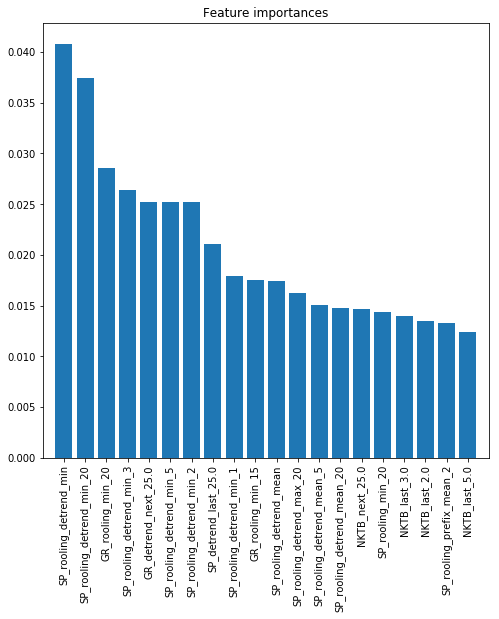

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
d_first = 20
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(features.columns)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

In [7]:
def get_Ridge_GridSearchCV(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                        labels, 
                                                        random_state=18, 
                                                        test_size=0.3, 
                                                        stratify=labels)

    ridge_model = RidgeClassifier(random_state=18)
    params = {}
    ridge_model_cv = GridSearchCV(ridge_model, params, cv = 5)
    ridge_model_cv.fit(X_train, y_train)
    
    p(y_test, ridge_model_cv.best_estimator_.predict(X_test).round())
    p_cross_val(ridge_model_cv.best_estimator_, train, labels)
    return ridge_model_cv


get_Ridge_GridSearchCV(features, target_facies)


RMSE ошибка равна 4.052554744525548
              precision    recall  f1-score   support

           0       0.86      0.61      0.72        70
           1       0.90      1.00      0.95        26
           3       1.00      0.04      0.08        24
           5       0.77      0.93      0.84       326
           7       0.74      0.77      0.75       174
           8       0.86      0.58      0.69        33
          12       1.00      0.22      0.36        32

   micro avg       0.78      0.78      0.78       685
   macro avg       0.88      0.59      0.63       685
weighted avg       0.80      0.78      0.75       685

cross_val_predict
              precision    recall  f1-score   support

           0       0.19      0.16      0.18       233
           1       0.89      0.84      0.86        86
           3       0.00      0.00      0.00        81
           5       0.61      0.70      0.65      1087
           7       0.50      0.54      0.52       580
           8       0.44 

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=18, solver='auto',
        tol=0.001),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       233
           1       1.00      1.00      1.00        86
           3       1.00      1.00      1.00        81
           5       1.00      1.00      1.00      1087
           7       1.00      1.00      1.00       580
           8       1.00      1.00      1.00       110
          12       1.00      1.00      1.00       105

   micro avg       1.00      1.00      1.00      2282
   macro avg       1.00      1.00      1.00      2282
weighted avg       1.00      1.00      1.00      2282

cross_val_predict
              precision    recall  f1-score   support

           0       0.70      0.43      0.54       233
           1       0.88      0.85      0.86        86
           3       0.97      0.96      0.97        81
           5       0.78      0.89      0.83      1087
           7       0.79      0.72      0.75       580
           8       0.77      0.77     

In [138]:
def check_OneVsRestClassifier_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9, stratify=labels)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    for i in range(1, 5):
        reg = RandomForestClassifier(random_state = i, bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, verbose=0, warm_start=False)

        OVR = OneVsRestClassifier(reg,n_jobs=-1)
        OVR.fit(X_train, y_train)
    
        p(y_test, OVR.predict(X_test).round())
    return OVR

check_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 1.5085324232081911
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       210
           1       0.97      0.91      0.94        77
           3       1.00      1.00      1.00        73
           5       0.89      0.98      0.94       975
           7       0.91      0.87      0.89       522
           8       0.84      0.78      0.81        99
          12       1.00      0.82      0.90        95

   micro avg       0.91      0.91      0.91      2051
   macro avg       0.94      0.87      0.90      2051
weighted avg       0.91      0.91      0.91      2051

RMSE ошибка равна 1.5177961969770843
              precision    recall  f1-score   support

           0       0.97      0.75      0.84       210
           1       0.97      0.90      0.93        77
           3       1.00      1.00      1.00        73
           5       0.90      0.98      0.94       975
           7       0.91      0.88      0.90       522
    

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=4, verbose=0, warm_start=False),
          n_jobs=-1)

In [17]:
def get_catBoost_GridSearchCV_prod(train, labels):
    from catboost import CatBoostClassifier, Pool
     
    model = CatBoostClassifier(iterations=108,
                               depth=10,
                               loss_function='MultiClass',
                           logging_level='Silent')
    model.fit(train, labels)
    p_cross_val(model, train, labels)

    return model
    
catboost_GridSearchCV_model_best_prod = get_catBoost_GridSearchCV_prod(features, target_facies)

cross_val_predict
              precision    recall  f1-score   support

           0       0.66      0.45      0.53       233
           1       0.93      0.90      0.91        86
           3       0.94      0.90      0.92        81
           5       0.77      0.90      0.83      1087
           7       0.75      0.68      0.71       580
           8       0.76      0.63      0.69       110
          12       1.00      0.70      0.82       105

   micro avg       0.77      0.77      0.77      2282
   macro avg       0.83      0.73      0.77      2282
weighted avg       0.77      0.77      0.77      2282



In [14]:

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    wells = []
    for name in wall_names_:
        display(name)
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells


def get_correct_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_new = []
    for well in wells:
        if is_md_correct(well):
            wells_new.append(well)
        else:
            print(well['wellName'].iloc[0])
            #print_md_not_correct(well)
    return wells_new


def add_wells_features(wells, features_for_detrend):
    wells_new = []
    for well in wells:
        wells_new.append(detrend(well, features_for_detrend))
    return wells_new


def detrend(df, features_for_detrend):
    undefined_value = -9999

    def corrector_detrend(row, name_base, name_detrend):
        if row[name_base] < -999:
            return undefined_value
        if row[name_base] > 500:
            return undefined_value
        if row[name_detrend] > 999:
            return undefined_value
        if row[name_detrend] < -999:
            return undefined_value
        return row[name_detrend]

    import math
    def corrector_nulls(value):
        if math.isnan(value):
            return undefined_value
        if math.isinf(value):
            return undefined_value
        if value == 'NaN':
            return undefined_value
        return value

    def remove_trend(serials):
        from scipy import signal
        return signal.detrend(serials)

    copy_df = df.copy()

    for feature in features_for_detrend:
        prefix = '_det'
        copy_df[feature + prefix] = copy_df[feature] - copy_df[feature].shift(-1)
        copy_df[feature] = copy_df[feature].apply(corrector_nulls)
        copy_df[feature + prefix] = remove_trend(copy_df[feature])
        copy_df[feature + '_detrend'] = copy_df.apply(
            lambda row: corrector_detrend(row, feature, feature + prefix), axis=1)
        del copy_df[feature + prefix]
    return copy_df

def get_problem_wells(wells):
    def is_md_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        copy_df_ = copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001]
        return copy_df_.empty

    def print_md_not_correct(df_):
        copy_df_ = df_.copy()
        copy_df_['MD_difference'] = abs(copy_df_['MD'] - copy_df_['MD'].shift(1))
        display(copy_df_[copy_df_['MD_difference'] - 0.2 > 0.001])

    wells_problem = []
    for well in wells:
        if is_md_correct(well) == False:
            if well['wellName'].iloc[0] not in ['spk1725', 'spk404', 'spk820PL']:
                print(well['wellName'].iloc[0])
                print_md_not_correct(well)
                wells_problem.append(well)
    return wells_problem

def get_for_learn_clean_df_prod(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    # feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["GR"] >= -999]
    feature = feature[feature["SP"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    return feature


name_dataset_for_predict = 'TRAIN18PRED.csv'
wells_for_predict = get_for_learn_clean_df_prod(pd.read_csv(name_dataset_for_predict, sep=';'))
display(wells_for_predict.describe())
wells_samples_for_predict_df = get_well_dfs(wells_for_predict)
wells_problem = get_problem_wells(wells_samples_for_predict_df)
wells_correct = get_correct_wells(wells_samples_for_predict_df)
#wells_add_detrends_for_predict_df = add_wells_features(wells_correct, ['SP', 'GR', 'BK', 'NKTB'])
display(wells_problem.describe())

MD            BK             GR            LIT  \
count  496940.000000  3.860640e+05  496940.000000  358457.000000   
mean     2252.423294 -4.924232e+02       9.516297   -6040.855218   
std       383.870595  1.054384e+04       5.970684    4890.668929   
min       502.000000 -9.999000e+03       0.000000   -9999.000000   
25%      1988.200000  4.600000e+00       7.027000   -9999.000000   
50%      2259.600000  6.380000e+00       8.661500   -9999.000000   
75%      2528.600000  8.340000e+00      10.685175       1.000000   
max      3252.400000  6.402033e+06     164.851000       6.000000   

                NKTB             SP  
count  496940.000000  496940.000000  
mean     -277.181626      86.108104  
std      1652.335183      36.826006  
min     -9999.000000    -129.180000  
25%         2.790000      57.488750  
50%         3.529675      85.380000  
75%         4.170000     113.257175  
max        30.500000     232.902900

'spk1059L'

'spk1061'

'spk1062'

'spk1205L'

'spk1245PL'

'spk146R'

'spk1504'

'spk1506L'

'spk1508'

'spk1515'

'spk1517'

'spk1518L'

'spk1519L'

'spk1523'

'spk1524'

'spk1525'

'spk1528'

'spk1529'

'spk1530'

'spk1531'

'spk1537'

'spk1650PL'

'spk1652PL'

'spk1654PL'

'spk1656PL'

'spk1660PA'

'spk1662PL'

'spk1663'

'spk1664PL'

'spk1665PL'

'spk1700'

'spk1701'

'spk1702'

'spk1703'

'spk1704'

'spk1705'

'spk1706L'

'spk1707'

'spk1708'

'spk1709'

'spk1710'

'spk1718'

'spk1725'

'spk1740'

'spk1741'

'spk1742'

'spk1745L'

'spk1750'

'spk1753'

'spk1755'

'spk1760'

'spk1764'

'spk1765'

'spk1779'

'spk1785'

'spk1786'

'spk1791'

'spk1792'

'spk1793'

'spk1794'

'spk1796'

'spk1805'

'spk1821'

'spk1822PL'

'spk1826PL'

'spk214P'

'spk236'

'spk3203'

'spk3203PL'

'spk401'

'spk404'

'spk407R'

'spk408'

'spk421R'

'spk422R'

'spk425'

'spk437'

'spk467'

'spk490'

'spk564P'

'spk632'

'spk720PL'

'spk762PL'

'spk764PL'

'spk804'

'spk805'

'spk808'

'spk820PL'

'spk833R'

'spk870PL'

'spk872PL'

'spk902'

'spk904'

'spk908'

'spk914'

'spk924L'

'spk941'

'spk963L'

spk1245PL


wellName      MD  BK     GR  LAYER  LIT   NKTB     SP  MD_difference
40471  spk1245PL  2553.0 NaN  6.782  -9999  NaN  3.742  0.429            3.0
40578  spk1245PL  2574.4 NaN  6.499  -9999  NaN  3.799  0.889            2.0

spk1660PA


wellName      MD    BK    GR  LAYER  LIT    NKTB    SP  MD_difference
226485  spk1660PA  1830.2  9.48  5.64  -9999  NaN -9999.0  0.25            1.6
226490  spk1660PA  1831.2  4.71  4.70  -9999  NaN -9999.0  0.65            0.6

spk214P


wellName      MD    BK     GR  LAYER  LIT     NKTB        SP  \
626382  spk214P  2552.4  5.35  14.31  Georg  1.0  3.64499  145.6656   

        MD_difference  
626382            2.6

spk401


wellName      MD    BK    GR  LAYER     LIT      NKTB        SP  \
647262   spk401  1649.8  7.25  6.25  -9999 -9999.0  3.162259  103.3027   

        MD_difference  
647262            6.6

spk407R


wellName      MD     BK     GR  LAYER     LIT      NKTB        SP  \
681312  spk407R  2388.8  4.385  9.505  -9999 -9999.0  4.612137  112.5925   

        MD_difference  
681312            1.8

spk564P


wellName      MD   BK     GR  LAYER     LIT   NKTB        SP  \
738882  spk564P  2517.6  4.2  11.89  -9999 -9999.0  2.835  105.6619   

        MD_difference  
738882            4.0

spk833R


wellName      MD       BK    GR  LAYER     LIT      NKTB        SP  \
822011  spk833R  2292.0  11.1895  8.11  -9999 -9999.0  3.467796  69.11457   

        MD_difference  
822011            1.0

spk1245PL
spk1660PA
spk1725
spk214P
spk401
spk404
spk407R
spk564P
spk820PL
spk833R


AttributeError: 'list' object has no attribute 'describe'

In [10]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1245PL', 'spk1660PA', 'spk1725', 'spk214P', 'spk401', 'spk404',
       'spk407R', 'spk564P', 'spk820PL', 'spk833R'], dtype=object)

In [12]:
pd.concat(wells_problem)['wellName'].unique()

array(['spk1725', 'spk404', 'spk820PL'], dtype=object)

In [11]:
len(wells_samples_for_predict_df)

98

In [12]:
len(wells_add_detrends_for_predict_df)

88

In [13]:
well_with_features_for_predict = get_well_with_features_df(wells_add_detrends_for_predict_df)
for_ml_preprocessing_for_predict = pd.concat(well_with_features_for_predict)


def get_md_for_predict(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
                name_feature != 'LIT' and
           name_feature != 'datasetName'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['wellName']
    del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_for_predict)
for_predict_df = get_features_for_predict(for_predict_df_prod)


      wellName      MD       BK    GR  LAYER     LIT      NKTB     SP  \
0     spk1059L  1765.0     2.33  6.90  -9999 -9999.0  3.759897  72.09   
1     spk1059L  1765.2     2.28  6.78  -9999 -9999.0  3.735977  70.69   
2     spk1059L  1765.4     2.24  6.86  -9999 -9999.0  3.679740  71.18   
3     spk1059L  1765.6     2.23  7.05  -9999 -9999.0  3.594239  69.51   
4     spk1059L  1765.8     2.55  7.16  -9999 -9999.0  3.553020  68.44   
5     spk1059L  1766.0     2.94  7.41  -9999 -9999.0  3.452698  67.90   
6     spk1059L  1766.2     2.76  7.86  -9999 -9999.0  3.311324  68.15   
7     spk1059L  1766.4     2.70  8.35  -9999 -9999.0  3.302620  68.99   
8     spk1059L  1766.6     2.69  8.68  -9999 -9999.0  3.380386  69.74   
9     spk1059L  1766.8     2.68  8.76  -9999 -9999.0  3.456919  70.32   
10    spk1059L  1767.0     2.66  8.95  -9999 -9999.0  3.494744  70.93   
11    spk1059L  1767.2     2.65  8.86  -9999 -9999.0  3.561290  72.36   
12    spk1059L  1767.4     2.65  8.43  -9999 -9999.

      wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  SP_detrend  \
5191   spk1061  1720.0   2.52   8.46  -9999 -9999.0  3.46  117.68  -12.613185   
5192   spk1061  1720.2   2.54   8.92  -9999 -9999.0  3.43  117.73  -12.557108   
5193   spk1061  1720.4   2.94   9.32  -9999 -9999.0  3.27  117.68  -12.601031   
5194   spk1061  1720.6   2.82   9.48  -9999 -9999.0  3.13  117.61  -12.664955   
5195   spk1061  1720.8   2.76   9.62  -9999 -9999.0  3.17  117.78  -12.488878   
5196   spk1061  1721.0   2.46   9.68  -9999 -9999.0  3.12  117.78  -12.482801   
5197   spk1061  1721.2   2.79   9.40  -9999 -9999.0  3.15  117.11  -13.146724   
5198   spk1061  1721.4   2.81   9.14  -9999 -9999.0  3.31  116.80  -13.450647   
5199   spk1061  1721.6   2.92   9.22  -9999 -9999.0  3.44  116.49  -13.754570   
5200   spk1061  1721.8   2.48   9.29  -9999 -9999.0  3.44  116.43  -13.808493   
5201   spk1061  1722.0   2.07   8.79  -9999 -9999.0  3.50  116.72  -13.512416   
5202   spk1061  1722.2   1.9

      wellName      MD       BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
17583  spk1062  1893.6 -9999.00  11.18  -9999  NaN  2.57  24.89   -2.392164   
17584  spk1062  1893.8 -9999.00  10.66  -9999  NaN  2.46  24.41   -2.877934   
17585  spk1062  1894.0 -9999.00  10.48  -9999  NaN  2.49  24.39   -2.903705   
17586  spk1062  1894.2 -9999.00  10.27  -9999  NaN  2.67  24.96   -2.339475   
17587  spk1062  1894.4 -9999.00   9.61  -9999  NaN  2.72  25.05   -2.255245   
17588  spk1062  1894.6 -9999.00   8.90  -9999  NaN  2.70  25.10   -2.211015   
17589  spk1062  1894.8 -9999.00   8.73  -9999  NaN  2.63  25.22   -2.096785   
17590  spk1062  1895.0 -9999.00   9.19  -9999  NaN  2.66  25.50   -1.822555   
17591  spk1062  1895.2 -9999.00   9.77  -9999  NaN  2.67  25.61   -1.718325   
17592  spk1062  1895.4 -9999.00  10.14  -9999  NaN  2.65  25.21   -2.124095   
17593  spk1062  1895.6 -9999.00  10.25  -9999  NaN  2.68  25.10   -2.239865   
17594  spk1062  1895.8 -9999.00   9.85  -9999  NaN  

       wellName      MD     BK    GR  LAYER  LIT  NKTB      SP  SP_detrend  \
31516  spk1205L  1698.0   0.12  7.18  -9999  NaN  1.87  -83.71 -118.069097   
31517  spk1205L  1698.2   0.03  7.06  -9999  NaN  1.73  -85.48 -119.852819   
31518  spk1205L  1698.4   0.00  6.51  -9999  NaN  1.60  -87.70 -122.086541   
31519  spk1205L  1698.6   2.00  6.32  -9999  NaN  1.66  -90.35 -124.750263   
31520  spk1205L  1698.8   0.03  6.51  -9999  NaN  1.81  -92.85 -127.263985   
31521  spk1205L  1699.0   0.03  6.72  -9999  NaN  1.82  -95.38 -129.807708   
31522  spk1205L  1699.2   0.31  7.29  -9999  NaN  1.84 -106.35 -140.791430   
31523  spk1205L  1699.4   0.17  7.36  -9999  NaN  1.94 -126.20 -160.655152   
31524  spk1205L  1699.6   0.03  6.71  -9999  NaN  1.93 -129.18 -163.648874   
31525  spk1205L  1699.8   0.17  6.26  -9999  NaN  1.93  -98.00 -132.482596   
31526  spk1205L  1700.0   0.00  6.67  -9999  NaN  1.87  -43.99  -78.486318   
31527  spk1205L  1700.2   0.03  6.95  -9999  NaN  1.74    6.02  

[936 rows x 168 columns]
      wellName      MD     BK     GR  LAYER     LIT      NKTB      SP  \
54949  spk1504  1818.0   4.15   9.74  -9999 -9999.0  3.465461   82.48   
54950  spk1504  1818.2   4.23  10.12  -9999 -9999.0  3.460559   79.92   
54951  spk1504  1818.4   4.26   9.88  -9999 -9999.0  3.475252   79.14   
54952  spk1504  1818.6   4.42   9.33  -9999 -9999.0  3.557847   79.93   
54953  spk1504  1818.8   4.97   8.73  -9999 -9999.0  3.747987   78.41   
54954  spk1504  1819.0   7.03   8.21  -9999 -9999.0  3.799305   77.64   
54955  spk1504  1819.2   6.29   8.45  -9999 -9999.0  3.620272   77.41   
54956  spk1504  1819.4   5.41   9.28  -9999 -9999.0  3.440913   77.25   
54957  spk1504  1819.6   4.24   9.45  -9999 -9999.0  3.341692   78.32   
54958  spk1504  1819.8   4.19   9.19  -9999 -9999.0  3.250923   81.27   
54959  spk1504  1820.0   4.24   9.10  -9999 -9999.0  3.189592   80.95   
54960  spk1504  1820.2   4.06   8.89  -9999 -9999.0  3.199861   79.41   
54961  spk1504  1820.4   4

       wellName      MD       BK     GR  LAYER     LIT  NKTB     SP  \
60104  spk1506L  1715.0     4.36   9.52  -9999 -9999.0  3.43  21.93   
60105  spk1506L  1715.2     4.66   9.43  -9999 -9999.0  3.73  22.19   
60106  spk1506L  1715.4     4.80   9.58  -9999 -9999.0  3.85  22.61   
60107  spk1506L  1715.6     4.74   9.76  -9999 -9999.0  3.65  22.70   
60108  spk1506L  1715.8     4.61   9.60  -9999 -9999.0  3.52  22.63   
60109  spk1506L  1716.0     4.78   9.66  -9999 -9999.0  3.49  22.02   
60110  spk1506L  1716.2     4.63  10.39  -9999 -9999.0  3.39  20.93   
60111  spk1506L  1716.4     4.33  10.17  -9999 -9999.0  3.39  20.83   
60112  spk1506L  1716.6     4.38   9.04  -9999 -9999.0  3.45  20.22   
60113  spk1506L  1716.8     4.47   8.69  -9999 -9999.0  3.53  18.49   
60114  spk1506L  1717.0     4.09   9.01  -9999 -9999.0  3.64  18.35   
60115  spk1506L  1717.2     3.95   9.31  -9999 -9999.0  3.70  18.54   
60116  spk1506L  1717.4     5.57   8.99  -9999 -9999.0  3.95  17.17   
60117 

      wellName      MD     BK      GR  LAYER     LIT     NKTB      SP  \
91191  spk1515  2034.0   4.50   7.329  -9999 -9999.0     2.44  113.86   
91192  spk1515  2034.2   4.66   7.421  -9999 -9999.0 -9999.00  112.18   
91193  spk1515  2034.4   4.75   7.522  -9999 -9999.0 -9999.00  112.35   
91194  spk1515  2034.6   4.69   7.504  -9999 -9999.0 -9999.00  113.95   
91195  spk1515  2034.8   4.71   7.628  -9999 -9999.0 -9999.00  113.55   
91196  spk1515  2035.0   4.91   7.858  -9999 -9999.0 -9999.00  113.38   
91197  spk1515  2035.2   4.55   8.135  -9999 -9999.0 -9999.00  115.05   
91198  spk1515  2035.4   4.47   8.392  -9999 -9999.0 -9999.00  115.43   
91199  spk1515  2035.6   4.43   8.307  -9999 -9999.0 -9999.00  114.24   
91200  spk1515  2035.8   4.44   8.182  -9999 -9999.0 -9999.00  114.66   
91201  spk1515  2036.0   4.29   8.166  -9999 -9999.0 -9999.00  115.75   
91202  spk1515  2036.2   4.27   8.175  -9999 -9999.0 -9999.00  114.47   
91203  spk1515  2036.4   4.37   8.330  -9999 -9999.

       wellName      MD     BK     GR  LAYER     LIT      NKTB      SP  \
96667   spk1517  1726.0   4.74   8.83  -9999 -9999.0  3.095541   28.80   
96668   spk1517  1726.2   4.90   9.39  -9999 -9999.0  3.303248   29.20   
96669   spk1517  1726.4   5.05   9.68  -9999 -9999.0  3.214926   29.80   
96670   spk1517  1726.6   5.05   9.51  -9999 -9999.0  3.045222   30.05   
96671   spk1517  1726.8   4.90   9.48  -9999 -9999.0  3.115572   29.51   
96672   spk1517  1727.0   4.74   9.50  -9999 -9999.0  3.105564   28.73   
96673   spk1517  1727.2   4.82   9.21  -9999 -9999.0  3.075455   27.99   
96674   spk1517  1727.4   4.74   9.02  -9999 -9999.0  3.185258   27.30   
96675   spk1517  1727.6   4.58   9.16  -9999 -9999.0  3.135549   26.28   
96676   spk1517  1727.8   4.19   9.20  -9999 -9999.0  2.974179   25.02   
96677   spk1517  1728.0   3.88   8.91  -9999 -9999.0  2.943511   23.90   
96678   spk1517  1728.2   3.41   7.94  -9999 -9999.0  2.994549   23.88   
96679   spk1517  1728.4   3.41   7.83 

        wellName      MD     BK     GR  LAYER     LIT     NKTB      SP  \
103673  spk1518L  2082.0   3.56   7.56  -9999 -9999.0 -9999.00  101.29   
103674  spk1518L  2082.2   4.57   6.21  -9999 -9999.0 -9999.00   99.86   
103675  spk1518L  2082.4   3.99   6.28  -9999 -9999.0 -9999.00   99.95   
103676  spk1518L  2082.6   3.41   7.91  -9999 -9999.0 -9999.00   99.24   
103677  spk1518L  2082.8   3.38   7.76  -9999 -9999.0 -9999.00   99.19   
103678  spk1518L  2083.0   3.50   8.04  -9999 -9999.0     4.99  100.70   
103679  spk1518L  2083.2   3.61   7.00  -9999 -9999.0     5.15  100.11   
103680  spk1518L  2083.4   3.44   7.34  -9999 -9999.0     5.99  100.77   
103681  spk1518L  2083.6   3.27   6.85  -9999 -9999.0     6.89  100.39   
103682  spk1518L  2083.8   2.92   6.74  -9999 -9999.0     6.54   98.34   
103683  spk1518L  2084.0   2.71   6.15  -9999 -9999.0     6.03   97.85   
103684  spk1518L  2084.2   2.70   6.88  -9999 -9999.0     5.94   97.31   
103685  spk1518L  2084.4   2.12   7.20

        wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
106431  spk1519L  1878.0   3.74   8.86  -9999 -9999.0  3.16  100.17   
106432  spk1519L  1878.2   3.92   8.85  -9999 -9999.0  3.14  100.07   
106433  spk1519L  1878.4   3.99   8.84  -9999 -9999.0  3.20  100.57   
106434  spk1519L  1878.6   4.20   8.76  -9999 -9999.0  3.18  100.89   
106435  spk1519L  1878.8   4.36   8.63  -9999 -9999.0  3.21  102.12   
106436  spk1519L  1879.0   4.50   8.48  -9999 -9999.0  3.25  102.92   
106437  spk1519L  1879.2   4.74   8.46  -9999 -9999.0  3.16  101.58   
106438  spk1519L  1879.4   4.82   8.63  -9999 -9999.0  3.07  101.48   
106439  spk1519L  1879.6   4.64   8.83  -9999 -9999.0  3.08  102.34   
106440  spk1519L  1879.8   4.66   8.88  -9999 -9999.0  2.93  103.11   
106441  spk1519L  1880.0   4.75   8.86  -9999 -9999.0  2.92  103.28   
106442  spk1519L  1880.2   4.89   8.71  -9999 -9999.0  2.88  102.97   
106443  spk1519L  1880.4   5.03   8.45  -9999 -9999.0  2.85  102.86   
106444

       wellName      MD    BK     GR  LAYER     LIT      NKTB     SP  \
111761  spk1523  1670.0  2.25   4.70  -9999 -9999.0  3.450895   70.5   
111762  spk1523  1670.2  2.25   4.41  -9999 -9999.0  3.527582   70.8   
111763  spk1523  1670.4  2.25   4.18  -9999 -9999.0  3.485047   70.7   
111764  spk1523  1670.6  2.13   4.43  -9999 -9999.0  3.544547   72.9   
111765  spk1523  1670.8  2.36   4.76  -9999 -9999.0  3.390851   72.3   
111766  spk1523  1671.0  2.48   4.93  -9999 -9999.0  3.356379   72.8   
111767  spk1523  1671.2  2.59   4.84  -9999 -9999.0  3.687674   72.3   
111768  spk1523  1671.4  2.59   5.17  -9999 -9999.0  3.861945   73.5   
111769  spk1523  1671.6  2.71   5.11  -9999 -9999.0  3.737743   70.6   
111770  spk1523  1671.8  2.59   5.12  -9999 -9999.0  3.485047   70.8   
111771  spk1523  1672.0  2.36   5.34  -9999 -9999.0  3.467985   69.9   
111772  spk1523  1672.2  2.25   4.95  -9999 -9999.0  3.536068   68.1   
111773  spk1523  1672.4  2.25   4.70  -9999 -9999.0  3.485047   

       wellName      MD      BK     GR  LAYER     LIT   NKTB     SP  \
116865  spk1524  1669.4    2.92   3.97  -9999 -9999.0   4.07  40.95   
116866  spk1524  1669.6    2.92   3.97  -9999 -9999.0   4.08  40.69   
116867  spk1524  1669.8    2.86   3.79  -9999 -9999.0   4.20  40.47   
116868  spk1524  1670.0    2.86   3.78  -9999 -9999.0   4.33  40.21   
116869  spk1524  1670.2    2.86   4.32  -9999 -9999.0   4.32  39.99   
116870  spk1524  1670.4    2.80   4.06  -9999 -9999.0   3.91  39.65   
116871  spk1524  1670.6    2.75   3.49  -9999 -9999.0   4.18  39.67   
116872  spk1524  1670.8    2.92   3.44  -9999 -9999.0   5.01  40.11   
116873  spk1524  1671.0    4.14   2.79  -9999 -9999.0   6.09  40.50   
116874  spk1524  1671.2    7.24   2.91  -9999 -9999.0   8.18  40.59   
116875  spk1524  1671.4   24.27   2.44  -9999 -9999.0  10.80  40.59   
116876  spk1524  1671.6  107.84   2.00  -9999 -9999.0  12.63  40.62   
116877  spk1524  1671.8  153.97   1.20  -9999 -9999.0  10.56  40.51   
116878

       wellName      MD    BK     GR  LAYER     LIT      NKTB      SP  \
121985  spk1525  1755.0  3.50  10.73  -9999 -9999.0  3.119140  135.44   
121986  spk1525  1755.2  3.40  10.50  -9999 -9999.0  3.057498  135.35   
121987  spk1525  1755.4  3.51   9.92  -9999 -9999.0  2.931261  136.80   
121988  spk1525  1755.6  3.68   9.53  -9999 -9999.0  2.952587  137.91   
121989  spk1525  1755.8  3.40   9.31  -9999 -9999.0  3.147588  137.94   
121990  spk1525  1756.0  3.38  10.47  -9999 -9999.0  3.171817  137.41   
121991  spk1525  1756.2  3.77  10.70  -9999 -9999.0  3.040899  136.28   
121992  spk1525  1756.4  3.69  10.27  -9999 -9999.0  2.990680  135.77   
121993  spk1525  1756.6  3.68  10.89  -9999 -9999.0  3.011683  136.28   
121994  spk1525  1756.8  3.78  10.58  -9999 -9999.0  3.028404  137.35   
121995  spk1525  1757.0  3.72   9.63  -9999 -9999.0  3.053355  137.45   
121996  spk1525  1757.2  3.51   9.08  -9999 -9999.0  2.994889  137.33   
121997  spk1525  1757.4  3.48   8.58  -9999 -9999.0

       wellName      MD      BK    GR  LAYER     LIT  NKTB     SP  SP_detrend  \
151479  spk1529  1894.0    3.17  7.16  -9999 -9999.0  2.70  35.38   -4.920863   
151480  spk1529  1894.2    3.03  6.80  -9999 -9999.0  2.97  35.06   -5.248493   
151481  spk1529  1894.4    3.20  6.59  -9999 -9999.0  3.18  37.27   -3.046124   
151482  spk1529  1894.6    3.62  6.89  -9999 -9999.0  2.63  37.39   -2.933754   
151483  spk1529  1894.8    3.66  6.83  -9999 -9999.0  2.53  37.16   -3.171385   
151484  spk1529  1895.0    3.57  6.48  -9999 -9999.0  2.70  37.46   -2.879015   
151485  spk1529  1895.2    3.47  6.02  -9999 -9999.0  2.91  37.12   -3.226646   
151486  spk1529  1895.4    3.82  5.32  -9999 -9999.0  3.31  37.68   -2.674276   
151487  spk1529  1895.6    4.08  4.75  -9999 -9999.0  4.89  38.59   -1.771907   
151488  spk1529  1895.8    4.08  4.40  -9999 -9999.0  6.76  39.23   -1.139537   
151489  spk1529  1896.0    3.92  4.05  -9999 -9999.0  6.45  39.64   -0.737168   
151490  spk1529  1896.2    3

       wellName      MD     BK     GR  LAYER     LIT      NKTB     SP  \
165686  spk1530  1796.0   3.26   8.55  -9999 -9999.0  3.194742  64.03   
165687  spk1530  1796.2   4.67   9.33  -9999 -9999.0  3.219393  63.34   
165688  spk1530  1796.4   4.65   9.33  -9999 -9999.0  3.273214  63.23   
165689  spk1530  1796.6   4.42   9.47  -9999 -9999.0  3.204617  63.86   
165690  spk1530  1796.8   3.75   9.51  -9999 -9999.0  3.110025  64.02   
165691  spk1530  1797.0   3.95   9.37  -9999 -9999.0  3.184849  64.26   
165692  spk1530  1797.2   4.04   9.67  -9999 -9999.0  3.268344  62.78   
165693  spk1530  1797.4   4.17   9.85  -9999 -9999.0  3.214472  60.46   
165694  spk1530  1797.6   4.27   9.68  -9999 -9999.0  3.179895  60.71   
165695  spk1530  1797.8   3.94   9.34  -9999 -9999.0  3.194742  61.71   
165696  spk1530  1798.0   3.62   9.31  -9999 -9999.0  3.140088  62.26   
165697  spk1530  1798.2   3.36   9.57  -9999 -9999.0  3.184849  63.36   
165698  spk1530  1798.4   3.38   9.58  -9999 -9999.

       wellName      MD     BK    GR  LAYER     LIT      NKTB      SP  \
180572  spk1531  1974.0   4.14  7.22  -9999 -9999.0  2.060000   94.27   
180573  spk1531  1974.2   4.24  7.13  -9999 -9999.0  2.160000   96.24   
180574  spk1531  1974.4   4.32  6.80  -9999 -9999.0  2.240000   98.80   
180575  spk1531  1974.6   4.53  6.48  -9999 -9999.0  2.350000  100.25   
180576  spk1531  1974.8   5.70  6.33  -9999 -9999.0  2.620000  100.27   
180577  spk1531  1975.0   9.88  6.28  -9999 -9999.0  2.980000   98.46   
180578  spk1531  1975.2  14.62  6.08  -9999 -9999.0  3.300000   95.96   
180579  spk1531  1975.4  23.88  5.92  -9999 -9999.0  3.400000   94.01   
180580  spk1531  1975.6  22.27  6.10  -9999 -9999.0  3.130000   92.31   
180581  spk1531  1975.8   7.13  6.42  -9999 -9999.0  2.290000   91.86   
180582  spk1531  1976.0   4.35  6.47  -9999 -9999.0  2.000000   92.47   
180583  spk1531  1976.2   3.72  6.67  -9999 -9999.0  1.920000   93.49   
180584  spk1531  1976.4   3.51  6.73  -9999 -9999.0

       wellName      MD     BK         GR  LAYER     LIT   NKTB      SP  \
195647  spk1537  1842.0   3.90   6.500000  -9999 -9999.0  2.910   90.98   
195648  spk1537  1842.2   4.52   5.930000  -9999 -9999.0  2.680   91.36   
195649  spk1537  1842.4   4.59   5.390000  -9999 -9999.0  2.690   91.00   
195650  spk1537  1842.6   4.25   5.130000  -9999 -9999.0  2.860   90.93   
195651  spk1537  1842.8   3.86   5.320000  -9999 -9999.0  2.610   91.94   
195652  spk1537  1843.0   3.64   5.760000  -9999 -9999.0  2.330   92.96   
195653  spk1537  1843.2   3.58   6.200000  -9999 -9999.0  2.270   93.94   
195654  spk1537  1843.4   3.67   6.330000  -9999 -9999.0  2.340   95.47   
195655  spk1537  1843.6   4.07   6.220000  -9999 -9999.0  2.280   96.35   
195656  spk1537  1843.8   4.67   6.050000  -9999 -9999.0  2.190   95.96   
195657  spk1537  1844.0   5.06   5.980000  -9999 -9999.0  2.400   95.66   
195658  spk1537  1844.2   4.44   5.990000  -9999 -9999.0  2.740   95.58   
195659  spk1537  1844.4  

         wellName      MD    BK      GR  LAYER  LIT   NKTB     SP  SP_detrend  \
201502  spk1650PL  1772.0 -9999   6.299  -9999  NaN   4.66   1.61  -40.726825   
201503  spk1650PL  1772.2 -9999   6.401  -9999  NaN   4.80   0.00  -42.343355   
201504  spk1650PL  1772.4 -9999   6.150  -9999  NaN   4.59   0.16  -42.189884   
201505  spk1650PL  1772.6 -9999   6.299  -9999  NaN   4.51   0.48  -41.876414   
201506  spk1650PL  1772.8 -9999   6.240  -9999  NaN   5.04   1.13  -41.232943   
201507  spk1650PL  1773.0 -9999   6.484  -9999  NaN   4.87   2.56  -39.809473   
201508  spk1650PL  1773.2 -9999   6.366  -9999  NaN   5.33   3.83  -38.546002   
201509  spk1650PL  1773.4 -9999   6.901  -9999  NaN   4.82   4.46  -37.922532   
201510  spk1650PL  1773.6 -9999   6.551  -9999  NaN   5.03   5.16  -37.229061   
201511  spk1650PL  1773.8 -9999   6.535  -9999  NaN   4.92   6.73  -35.665591   
201512  spk1650PL  1774.0 -9999   6.909  -9999  NaN   4.64   7.20  -35.202120   
201513  spk1650PL  1774.2 -9

         wellName      MD    BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
207098  spk1652PL  1800.0 -9999  10.68  -9999  NaN  3.19  94.23   12.316666   
207099  spk1652PL  1800.2 -9999  10.02  -9999  NaN  3.27  93.07   11.159913   
207100  spk1652PL  1800.4 -9999   8.81  -9999  NaN  3.09  90.03    8.123159   
207101  spk1652PL  1800.6 -9999   8.08  -9999  NaN  3.18  87.46    5.556406   
207102  spk1652PL  1800.8 -9999   8.00  -9999  NaN  3.53  85.36    3.459653   
207103  spk1652PL  1801.0 -9999   7.77  -9999  NaN  3.84  83.62    1.722900   
207104  spk1652PL  1801.2 -9999   7.77  -9999  NaN  3.86  82.16    0.266147   
207105  spk1652PL  1801.4 -9999   7.84  -9999  NaN  4.00  81.43   -0.460606   
207106  spk1652PL  1801.6 -9999   8.08  -9999  NaN  4.02  81.44   -0.447359   
207107  spk1652PL  1801.8 -9999   8.31  -9999  NaN  3.83  81.98    0.095887   
207108  spk1652PL  1802.0 -9999   8.89  -9999  NaN  3.68  81.87   -0.010866   
207109  spk1652PL  1802.2 -9999   8.17  -9999  NaN  

         wellName      MD    BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
212999  spk1654PL  1850.0 -9999   9.12  -9999  NaN  2.94  39.92    2.800546   
213000  spk1654PL  1850.2 -9999   9.30  -9999  NaN  2.93  39.47    2.343150   
213001  spk1654PL  1850.4 -9999   9.19  -9999  NaN  3.04  38.74    1.605754   
213002  spk1654PL  1850.6 -9999   9.19  -9999  NaN  3.13  37.29    0.148359   
213003  spk1654PL  1850.8 -9999   9.35  -9999  NaN  3.09  35.02   -2.129037   
213004  spk1654PL  1851.0 -9999   7.96  -9999  NaN  2.88  32.27   -4.886433   
213005  spk1654PL  1851.2 -9999   7.54  -9999  NaN  2.94  30.08   -7.083828   
213006  spk1654PL  1851.4 -9999   7.96  -9999  NaN  2.85  29.01   -8.161224   
213007  spk1654PL  1851.6 -9999   7.59  -9999  NaN  2.93  28.58   -8.598620   
213008  spk1654PL  1851.8 -9999   8.27  -9999  NaN  2.82  28.51   -8.676016   
213009  spk1654PL  1852.0 -9999   8.88  -9999  NaN  2.79  29.11   -8.083411   
213010  spk1654PL  1852.2 -9999   8.91  -9999  NaN  

         wellName      MD    BK     GR  LAYER  LIT   NKTB     SP  SP_detrend  \
218972  spk1656PL  1700.0 -9999   8.15  -9999  NaN   3.28  23.04  -16.781209   
218973  spk1656PL  1700.2 -9999   8.63  -9999  NaN   3.44  23.31  -16.515371   
218974  spk1656PL  1700.4 -9999   8.80  -9999  NaN   3.17  23.69  -16.139534   
218975  spk1656PL  1700.6 -9999   8.50  -9999  NaN   3.02  24.22  -15.613696   
218976  spk1656PL  1700.8 -9999   8.47  -9999  NaN   3.42  24.73  -15.107858   
218977  spk1656PL  1701.0 -9999   9.00  -9999  NaN   3.26  25.21  -14.632020   
218978  spk1656PL  1701.2 -9999   9.56  -9999  NaN   2.97  25.98  -13.866182   
218979  spk1656PL  1701.4 -9999   9.36  -9999  NaN   3.25  27.32  -12.530344   
218980  spk1656PL  1701.6 -9999   9.47  -9999  NaN   3.33  28.88  -10.974506   
218981  spk1656PL  1701.8 -9999   9.83  -9999  NaN   3.08  30.49   -9.368668   
218982  spk1656PL  1702.0 -9999   9.13  -9999  NaN   3.04  32.38   -7.482831   
218983  spk1656PL  1702.2 -9999   8.20  

         wellName      MD    BK    GR  LAYER  LIT  NKTB     SP  SP_detrend  \
231730  spk1662PL  1900.0 -9999  7.39  -9999  NaN  3.46  18.82    9.214549   
231731  spk1662PL  1900.2 -9999  6.76  -9999  NaN  3.32  18.89    9.271491   
231732  spk1662PL  1900.4 -9999  6.89  -9999  NaN  3.22  18.97    9.338433   
231733  spk1662PL  1900.6 -9999  7.14  -9999  NaN  3.13  19.08    9.435374   
231734  spk1662PL  1900.8 -9999  7.26  -9999  NaN  3.06  19.24    9.582316   
231735  spk1662PL  1901.0 -9999  7.23  -9999  NaN  3.04  19.40    9.729258   
231736  spk1662PL  1901.2 -9999  7.24  -9999  NaN  3.03  19.74   10.056199   
231737  spk1662PL  1901.4 -9999  7.62  -9999  NaN  3.24  20.08   10.383141   
231738  spk1662PL  1901.6 -9999  8.00  -9999  NaN  3.45  20.53   10.820083   
231739  spk1662PL  1901.8 -9999  7.54  -9999  NaN  3.77  21.06   11.337024   
231740  spk1662PL  1902.0 -9999  6.72  -9999  NaN  4.14  21.61   11.873966   
231741  spk1662PL  1902.2 -9999  6.34  -9999  NaN  4.34  22.23  

       wellName      MD    BK    GR  LAYER  LIT  NKTB     SP  SP_detrend  \
248006  spk1663  1998.4 -9999  7.10  -9999  NaN  2.42  84.61    6.068730   
248007  spk1663  1998.6 -9999  7.15  -9999  NaN  2.59  84.61    6.074617   
248008  spk1663  1998.8 -9999  7.16  -9999  NaN  2.60  83.61    5.080504   
248009  spk1663  1999.0 -9999  7.41  -9999  NaN  2.66  82.44    3.916391   
248010  spk1663  1999.2 -9999  7.33  -9999  NaN  2.68  81.54    3.022278   
248011  spk1663  1999.4 -9999  7.00  -9999  NaN  2.84  80.68    2.168165   
248012  spk1663  1999.6 -9999  6.60  -9999  NaN  3.23  79.53    1.024051   
248013  spk1663  1999.8 -9999  6.34  -9999  NaN  3.93  78.22   -0.280062   
248014  spk1663  2000.0 -9999  5.41  -9999  NaN  4.36  77.22   -1.274175   
248015  spk1663  2000.2 -9999  4.60  -9999  NaN  4.36  76.68   -1.808288   
248016  spk1663  2000.4 -9999  4.65  -9999  NaN  4.18  76.44   -2.042401   
248017  spk1663  2000.6 -9999  5.20  -9999  NaN  3.76  77.16   -1.316515   
248018  spk1

         wellName      MD    BK     GR  LAYER  LIT  NKTB      SP  SP_detrend  \
253929  spk1664PL  1732.0 -9999   7.70  -9999  NaN  2.21  106.69   10.530244   
253930  spk1664PL  1732.2 -9999   8.26  -9999  NaN  2.40  103.60    7.437998   
253931  spk1664PL  1732.4 -9999   8.77  -9999  NaN  2.68  100.22    4.055752   
253932  spk1664PL  1732.6 -9999   8.94  -9999  NaN  2.91   99.29    3.123506   
253933  spk1664PL  1732.8 -9999   8.92  -9999  NaN  2.89   98.25    2.081259   
253934  spk1664PL  1733.0 -9999   8.52  -9999  NaN  2.85   97.98    1.809013   
253935  spk1664PL  1733.2 -9999   8.49  -9999  NaN  2.76   97.55    1.376767   
253936  spk1664PL  1733.4 -9999   8.83  -9999  NaN  2.63   97.11    0.934520   
253937  spk1664PL  1733.6 -9999   8.88  -9999  NaN  2.56   97.04    0.862274   
253938  spk1664PL  1733.8 -9999   9.06  -9999  NaN  2.59   97.50    1.320028   
253939  spk1664PL  1734.0 -9999   8.87  -9999  NaN  2.60   97.80    1.617781   
253940  spk1664PL  1734.2 -9999   8.29  

         wellName      MD       BK      GR  LAYER  LIT      NKTB      SP  \
259560  spk1665PL  1802.2 -9999.00   8.454  -9999  NaN -9999.000   19.99   
259561  spk1665PL  1802.4 -9999.00   8.575  -9999  NaN -9999.000   20.09   
259562  spk1665PL  1802.6 -9999.00   8.215  -9999  NaN -9999.000   20.09   
259563  spk1665PL  1802.8 -9999.00   7.974  -9999  NaN -9999.000   19.80   
259564  spk1665PL  1803.0 -9999.00   8.095  -9999  NaN -9999.000   19.69   
259565  spk1665PL  1803.2 -9999.00   7.855  -9999  NaN -9999.000   19.40   
259566  spk1665PL  1803.4 -9999.00   7.735  -9999  NaN     3.950   19.00   
259567  spk1665PL  1803.6 -9999.00   7.735  -9999  NaN     3.907   18.70   
259568  spk1665PL  1803.8 -9999.00   7.974  -9999  NaN     3.824   18.40   
259569  spk1665PL  1804.0 -9999.00   7.974  -9999  NaN     3.873   18.09   
259570  spk1665PL  1804.2 -9999.00   7.614  -9999  NaN     3.831   17.99   
259571  spk1665PL  1804.4 -9999.00   7.494  -9999  NaN     3.765   17.89   
259572  spk1

       wellName      MD     BK     GR  LAYER     LIT         NKTB         SP  \
265235  spk1700  1790.0   7.83   5.89  -9999 -9999.0 -9999.000000   73.12003   
265236  spk1700  1790.2   7.04   5.91  -9999 -9999.0 -9999.000000   75.26003   
265237  spk1700  1790.4   8.29   6.09  -9999 -9999.0 -9999.000000   78.85003   
265238  spk1700  1790.6   8.16   6.31  -9999 -9999.0 -9999.000000   84.38003   
265239  spk1700  1790.8   8.13   6.31  -9999 -9999.0 -9999.000000   89.09003   
265240  spk1700  1791.0   7.52   6.17  -9999 -9999.0 -9999.000000   90.79003   
265241  spk1700  1791.2   7.36   6.16  -9999 -9999.0 -9999.000000   89.81003   
265242  spk1700  1791.4   8.90   6.00  -9999 -9999.0 -9999.000000   87.98003   
265243  spk1700  1791.6   8.62   5.95  -9999 -9999.0 -9999.000000   86.16003   
265244  spk1700  1791.8   8.81   5.96  -9999 -9999.0 -9999.000000   83.99003   
265245  spk1700  1792.0   9.23   5.86  -9999 -9999.0 -9999.000000   82.00003   
265246  spk1700  1792.2   8.60   5.78  -

       wellName      MD     BK    GR  LAYER     LIT      NKTB         SP  \
278791  spk1701  1685.0   7.72  4.50  -9999 -9999.0  3.477058   80.76392   
278792  spk1701  1685.2   7.88  4.56  -9999 -9999.0  3.512222   81.53392   
278793  spk1701  1685.4   8.10  4.80  -9999 -9999.0  3.465298   81.76392   
278794  spk1701  1685.6   8.24  4.48  -9999 -9999.0  3.441722   82.50392   
278795  spk1701  1685.8   8.35  4.51  -9999 -9999.0  3.441722   82.07393   
278796  spk1701  1686.0   8.38  4.84  -9999 -9999.0  3.429904   82.31393   
278797  spk1701  1686.2   8.36  4.86  -9999 -9999.0  3.394334   83.32393   
278798  spk1701  1686.4   8.31  4.58  -9999 -9999.0  3.310633   84.88393   
278799  spk1701  1686.6   8.19  4.25  -9999 -9999.0  3.274450   85.68393   
278800  spk1701  1686.8   8.02  4.24  -9999 -9999.0  3.547218   86.23392   
278801  spk1701  1687.0   8.13  4.16  -9999 -9999.0  4.322642   87.11392   
278802  spk1701  1687.2  16.96  3.80  -9999 -9999.0  4.967025   88.80392   
278803  spk1

       wellName      MD   BK     GR  LAYER     LIT      NKTB        SP  \
283873  spk1702  1680.0  8.9   7.22  -9999 -9999.0  3.526115   63.4532   
283874  spk1702  1680.2  8.8   6.94  -9999 -9999.0  3.440793   63.4532   
283875  spk1702  1680.4  8.8   7.07  -9999 -9999.0  3.475132   63.5532   
283876  spk1702  1680.6  9.0   6.68  -9999 -9999.0  3.526115   63.9532   
283877  spk1702  1680.8  8.9   6.86  -9999 -9999.0  3.503533   64.4532   
283878  spk1702  1681.0  8.9   6.96  -9999 -9999.0  3.475132   65.2532   
283879  spk1702  1681.2  8.7   6.92  -9999 -9999.0  3.480827   66.3532   
283880  spk1702  1681.4  8.6   7.40  -9999 -9999.0  3.463717   66.8532   
283881  spk1702  1681.6  8.8   8.08  -9999 -9999.0  3.417740   66.6532   
283882  spk1702  1681.8  8.9   8.36  -9999 -9999.0  3.371239   66.5532   
283883  spk1702  1682.0  9.1   8.49  -9999 -9999.0  3.330106   66.4532   
283884  spk1702  1682.2  8.9   8.29  -9999 -9999.0  3.423515   66.4532   
283885  spk1702  1682.4  8.8   7.75  -

       wellName      MD      BK     GR  LAYER     LIT      NKTB         SP  \
297269  spk1703  1710.0    7.60   6.46  -9999 -9999.0  4.001027   68.46780   
297270  spk1703  1710.2    7.50   6.20  -9999 -9999.0  4.142132   68.46780   
297271  spk1703  1710.4    7.80   6.49  -9999 -9999.0  3.800667   71.66781   
297272  spk1703  1710.6    7.60   6.88  -9999 -9999.0  3.872615   71.16781   
297273  spk1703  1710.8    7.40   6.31  -9999 -9999.0  4.085883   67.06781   
297274  spk1703  1711.0    7.30   6.22  -9999 -9999.0  3.699176   67.46780   
297275  spk1703  1711.2    7.20   6.70  -9999 -9999.0  3.843889   67.66781   
297276  spk1703  1711.4    7.10   6.57  -9999 -9999.0  4.156155   67.86781   
297277  spk1703  1711.6    6.80   6.23  -9999 -9999.0  4.170162   67.56781   
297278  spk1703  1711.8    6.60   6.14  -9999 -9999.0  3.886952   69.06781   
297279  spk1703  1712.0    6.60   6.70  -9999 -9999.0  3.886952   69.46780   
297280  spk1703  1712.2    6.50   6.11  -9999 -9999.0  3.829500 

       wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
310534  spk1704  1675.0   5.56   8.46  -9999 -9999.0  4.356367  105.76400   
310535  spk1704  1675.2   4.97   7.81  -9999 -9999.0  3.929401  109.76400   
310536  spk1704  1675.4   6.39   6.59  -9999 -9999.0  3.459255  110.90400   
310537  spk1704  1675.6   8.35   6.07  -9999 -9999.0  3.514003  106.33400   
310538  spk1704  1675.8   9.03   6.22  -9999 -9999.0  3.810343   97.75401   
310539  spk1704  1676.0   9.02   5.84  -9999 -9999.0  3.876634   90.33401   
310540  spk1704  1676.2   8.99   6.54  -9999 -9999.0  3.916231   86.90401   
310541  spk1704  1676.4   9.23   6.64  -9999 -9999.0  3.995036   84.47401   
310542  spk1704  1676.6   9.44   6.02  -9999 -9999.0  4.047291   84.47401   
310543  spk1704  1676.8   9.66   5.25  -9999 -9999.0  4.034248   84.47401   
310544  spk1704  1677.0   9.40   5.09  -9999 -9999.0  3.743673   84.47401   
310545  spk1704  1677.2   9.64   6.05  -9999 -9999.0  3.876634   84.47401   

       wellName      MD     BK    GR  LAYER     LIT      NKTB         SP  \
315375  spk1705  1630.0   7.49  6.32  -9999 -9999.0  6.986793   95.22363   
315376  spk1705  1630.2   7.58  7.91  -9999 -9999.0  6.609164   97.43363   
315377  spk1705  1630.4   7.65  7.45  -9999 -9999.0  6.582491  100.83360   
315378  spk1705  1630.6   7.79  6.57  -9999 -9999.0  6.635876  104.93360   
315379  spk1705  1630.8   7.59  6.74  -9999 -9999.0  6.796997  109.19360   
315380  spk1705  1631.0   7.54  7.80  -9999 -9999.0  6.689421  112.54360   
315381  spk1705  1631.2   7.39  7.54  -9999 -9999.0  6.743129  114.76360   
315382  spk1705  1631.4   7.18  8.70  -9999 -9999.0  6.959559  116.78360   
315383  spk1705  1631.6   7.59  8.14  -9999 -9999.0  6.662628  118.14360   
315384  spk1705  1631.8   7.46  6.91  -9999 -9999.0  6.689421  118.56360   
315385  spk1705  1632.0   7.31  6.95  -9999 -9999.0  6.823989  118.39360   
315386  spk1705  1632.2   7.70  7.53  -9999 -9999.0  6.449740  117.50360   
315387  spk1

        wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
337692  spk1706L  1680.0   8.30   6.18  -9999 -9999.0  3.043145   88.29362   
337694  spk1706L  1680.2   8.60   6.32  -9999 -9999.0  3.363111   87.49362   
337696  spk1706L  1680.4   9.10   6.13  -9999 -9999.0  3.481825   86.61362   
337698  spk1706L  1680.6   9.26   5.80  -9999 -9999.0  3.286432   84.96362   
337700  spk1706L  1680.8   9.22   5.59  -9999 -9999.0  3.068463   83.10362   
337702  spk1706L  1681.0   9.65   5.59  -9999 -9999.0  2.956968   82.74362   
337704  spk1706L  1681.2  10.28   5.90  -9999 -9999.0  2.747036   82.85362   
337706  spk1706L  1681.4  10.22   6.29  -9999 -9999.0  2.718290   84.17361   
337708  spk1706L  1681.6  10.28   6.32  -9999 -9999.0  3.043145   86.70362   
337710  spk1706L  1681.8  10.46   6.25  -9999 -9999.0  3.263028   90.32362   
337712  spk1706L  1682.0  10.27   6.18  -9999 -9999.0  3.207664   94.05362   
337714  spk1706L  1682.2  10.46   6.12  -9999 -9999.0  3.101856 

       wellName      MD      BK     GR  LAYER     LIT      NKTB         SP  \
356001  spk1707  1690.0  210.89   4.34  -9999 -9999.0  5.836634   76.19930   
356002  spk1707  1690.2  111.94   4.47  -9999 -9999.0  5.251106   73.94930   
356003  spk1707  1690.4   53.06   4.78  -9999 -9999.0  4.394351   70.62930   
356004  spk1707  1690.6   26.29   5.39  -9999 -9999.0  3.799747   69.14931   
356005  spk1707  1690.8   10.51   5.95  -9999 -9999.0  3.547336   69.64931   
356006  spk1707  1691.0    9.13   6.00  -9999 -9999.0  3.457315   70.09930   
356007  spk1707  1691.2    9.24   5.93  -9999 -9999.0  3.514807   68.71931   
356008  spk1707  1691.4    9.39   5.90  -9999 -9999.0  3.539226   66.14931   
356009  spk1707  1691.6    9.19   5.77  -9999 -9999.0  3.555432   64.66930   
356010  spk1707  1691.8    9.25   5.73  -9999 -9999.0  3.603714   64.68930   
356011  spk1707  1692.0    9.35   5.65  -9999 -9999.0  3.531101   65.61930   
356012  spk1707  1692.2    9.70   5.38  -9999 -9999.0  3.440752 

       wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
378210  spk1708  1675.0   5.47  8.373  -9999 -9999.0  2.916759   98.74996   
378212  spk1708  1675.2   5.54  9.146  -9999 -9999.0  2.868752   99.78696   
378214  spk1708  1675.4   5.53  9.358  -9999 -9999.0  2.902701  100.47100   
378216  spk1708  1675.6   5.06  9.035  -9999 -9999.0  3.015614  100.21200   
378218  spk1708  1675.8   5.66  8.283  -9999 -9999.0  3.142302   99.10297   
378220  spk1708  1676.0   5.59  7.436  -9999 -9999.0  3.199435   97.31096   
378222  spk1708  1676.2   5.79  6.811  -9999 -9999.0  3.227283   94.03496   
378224  spk1708  1676.4   5.76  6.271  -9999 -9999.0  3.231619   92.17096   
378226  spk1708  1676.6   5.15  5.810  -9999 -9999.0  3.152025   90.73296   
378228  spk1708  1676.8   5.16  5.752  -9999 -9999.0  3.003733   91.18096   
378230  spk1708  1677.0   5.60  6.051  -9999 -9999.0  2.927037   92.78397   
378232  spk1708  1677.2   5.96  6.420  -9999 -9999.0  2.978946   94.22196   

       wellName      MD      BK     GR  LAYER     LIT  NKTB         SP  \
389731  spk1709  1770.0    7.48   6.67  -9999 -9999.0  2.01  129.07470   
389733  spk1709  1770.2    7.40   6.23  -9999 -9999.0  1.99  129.25970   
389735  spk1709  1770.4    7.56   6.19  -9999 -9999.0  2.08  129.88070   
389737  spk1709  1770.6    7.13   6.25  -9999 -9999.0  1.77  130.26870   
389739  spk1709  1770.8    6.44   6.40  -9999 -9999.0  1.80  130.55870   
389741  spk1709  1771.0    6.66   6.06  -9999 -9999.0  1.87  130.57970   
389743  spk1709  1771.2    6.69   6.40  -9999 -9999.0  1.79  129.37670   
389745  spk1709  1771.4    7.08   6.44  -9999 -9999.0  1.76  127.16070   
389747  spk1709  1771.6    6.97   6.29  -9999 -9999.0  1.98  124.66470   
389749  spk1709  1771.8    7.59   6.88  -9999 -9999.0  1.97  122.31270   
389751  spk1709  1772.0    7.65   6.39  -9999 -9999.0  2.01  120.22070   
389753  spk1709  1772.2    7.43   6.70  -9999 -9999.0  1.97  116.70670   
389755  spk1709  1772.4    7.74   7.15

       wellName      MD      BK    GR  LAYER     LIT      NKTB        SP  \
400071  spk1710  1640.2 -9999.0  3.88  -9999 -9999.0  3.187501  29.34716   
400072  spk1710  1640.4    10.2  4.19  -9999 -9999.0  3.187501  32.74716   
400073  spk1710  1640.6     9.6  5.07  -9999 -9999.0  3.139744  37.84716   
400074  spk1710  1640.8     8.9  5.83  -9999 -9999.0  3.052669  44.84716   
400075  spk1710  1641.0     7.5  6.04  -9999 -9999.0  2.954147  52.34716   
400076  spk1710  1641.2     7.3  6.36  -9999 -9999.0  2.944187  59.14716   
400077  spk1710  1641.4     7.3  6.56  -9999 -9999.0  2.974006  64.54716   
400078  spk1710  1641.6     7.1  6.60  -9999 -9999.0  2.904145  67.94716   
400079  spk1710  1641.8     6.8  6.24  -9999 -9999.0  2.843457  69.74716   
400080  spk1710  1642.0     7.0  5.70  -9999 -9999.0  2.792287  71.04716   
400081  spk1710  1642.2     7.0  5.79  -9999 -9999.0  2.635290  71.94716   
400082  spk1710  1642.4     7.3  6.37  -9999 -9999.0  2.667128  72.74716   
400083  spk1

       wellName      MD    BK    GR  LAYER  LIT  NKTB     SP  SP_detrend  \
404892  spk1718  1710.2   6.4  7.31  -9999  NaN  1.20   75.0    8.951251   
404893  spk1718  1710.4   7.0  7.12  -9999  NaN  1.20   71.9    5.843181   
404894  spk1718  1710.6   7.2  7.07  -9999  NaN  1.21   69.2    3.135111   
404895  spk1718  1710.8   6.9  7.13  -9999  NaN  1.21   68.7    2.627041   
404896  spk1718  1711.0   6.8  6.99  -9999  NaN  1.20   69.8    3.718970   
404897  spk1718  1711.2   6.6  6.50  -9999  NaN  1.19   71.6    5.510900   
404898  spk1718  1711.4   6.5  6.41  -9999  NaN  1.23   73.7    7.602830   
404899  spk1718  1711.6   6.7  6.72  -9999  NaN  1.26   74.1    7.994759   
404900  spk1718  1711.8   7.0  7.00  -9999  NaN  1.28   72.6    6.486689   
404901  spk1718  1712.0   7.0  7.28  -9999  NaN  1.28   70.9    4.778619   
404902  spk1718  1712.2   7.1  7.44  -9999  NaN  1.28   70.7    4.570549   
404903  spk1718  1712.4   6.8  7.56  -9999  NaN  1.28   72.6    6.462478   
404904  spk1

       wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
437377  spk1741  1691.0   6.23   6.74  -9999 -9999.0  2.33   64.36   
437378  spk1741  1691.2   5.85   7.84  -9999 -9999.0  2.49   65.68   
437379  spk1741  1691.4   4.91   7.51  -9999 -9999.0  2.34   69.34   
437380  spk1741  1691.6   4.23   6.58  -9999 -9999.0  1.96   72.90   
437381  spk1741  1691.8   5.05   6.98  -9999 -9999.0  1.54   75.30   
437382  spk1741  1692.0   7.39   7.56  -9999 -9999.0  1.66   78.60   
437383  spk1741  1692.2   4.04   7.71  -9999 -9999.0  1.97   79.85   
437384  spk1741  1692.4   4.49   7.41  -9999 -9999.0  1.97   80.09   
437385  spk1741  1692.6   5.07   7.69  -9999 -9999.0  2.40   79.97   
437386  spk1741  1692.8   4.10   7.46  -9999 -9999.0  2.43   81.70   
437387  spk1741  1693.0   3.56   7.66  -9999 -9999.0  2.39   83.20   
437388  spk1741  1693.2   3.82   7.80  -9999 -9999.0  2.22   80.84   
437389  spk1741  1693.4   5.25   7.71  -9999 -9999.0  2.60   78.36   
437390  spk1741  169

       wellName      MD       BK      GR  LAYER     LIT   NKTB      SP  \
442479  spk1742  1650.0     4.97  11.014  -9999 -9999.0  3.318  76.838   
442481  spk1742  1650.2     5.09  10.774  -9999 -9999.0  3.249  71.755   
442483  spk1742  1650.4     4.90  10.838  -9999 -9999.0  3.153  71.796   
442485  spk1742  1650.6     5.83  10.678  -9999 -9999.0  3.217  64.241   
442487  spk1742  1650.8     7.03  10.137  -9999 -9999.0  3.273  59.472   
442489  spk1742  1651.0     7.22   8.721  -9999 -9999.0  3.213  49.995   
442491  spk1742  1651.2     7.22   8.299  -9999 -9999.0  3.202  39.958   
442493  spk1742  1651.4     7.78   8.301  -9999 -9999.0  3.164  39.104   
442495  spk1742  1651.6     8.66   8.489  -9999 -9999.0  3.192  36.371   
442497  spk1742  1651.8     8.42   8.434  -9999 -9999.0  3.319  36.090   
442499  spk1742  1652.0     8.42   8.361  -9999 -9999.0  3.395  35.867   
442501  spk1742  1652.2     8.35   8.154  -9999 -9999.0  3.398  35.041   
442503  spk1742  1652.4     7.81   7.7

        wellName      MD       BK     GR  LAYER     LIT   NKTB      SP  \
452430  spk1745L  1884.0   134.20   4.56  -9999 -9999.0  11.15   60.96   
452431  spk1745L  1884.2   145.61   4.60  -9999 -9999.0  11.60   58.92   
452432  spk1745L  1884.4   142.77   4.88  -9999 -9999.0  10.69   57.11   
452433  spk1745L  1884.6    18.45   5.44  -9999 -9999.0   8.61   54.52   
452434  spk1745L  1884.8    10.62   5.76  -9999 -9999.0   6.75   52.54   
452435  spk1745L  1885.0     9.62   6.00  -9999 -9999.0   5.53   50.93   
452436  spk1745L  1885.2     9.44   6.06  -9999 -9999.0   5.23   50.95   
452437  spk1745L  1885.4     9.36   5.86  -9999 -9999.0   5.17   51.01   
452438  spk1745L  1885.6     9.22   5.97  -9999 -9999.0   5.09   51.64   
452439  spk1745L  1885.8     9.28   6.68  -9999 -9999.0   5.05   52.88   
452440  spk1745L  1886.0     9.04   7.09  -9999 -9999.0   5.00   55.42   
452441  spk1745L  1886.2     8.91   7.24  -9999 -9999.0   5.00   59.86   
452442  spk1745L  1886.4     8.64   7.

       wellName      MD       BK      GR  LAYER     LIT    NKTB       SP  \
457783  spk1750  1726.0     4.60   8.685  -9999 -9999.0   4.872   30.868   
457785  spk1750  1726.2     3.96   8.736  -9999 -9999.0   4.594   30.804   
457787  spk1750  1726.4     3.78   8.256  -9999 -9999.0   4.465   30.980   
457789  spk1750  1726.6     4.10   9.445  -9999 -9999.0   4.012   32.570   
457791  spk1750  1726.8     4.34   8.191  -9999 -9999.0   5.318   34.405   
457793  spk1750  1727.0     4.44   9.015  -9999 -9999.0   4.901   33.422   
457795  spk1750  1727.2     4.56   7.561  -9999 -9999.0   4.251   30.011   
457797  spk1750  1727.4     4.49   9.881  -9999 -9999.0   4.477   28.990   
457799  spk1750  1727.6     4.57   9.374  -9999 -9999.0   4.432   29.829   
457801  spk1750  1727.8     4.52   8.435  -9999 -9999.0   4.508   31.275   
457803  spk1750  1728.0     4.49   7.941  -9999 -9999.0   5.024   33.926   
457805  spk1750  1728.2     4.58   8.071  -9999 -9999.0   5.121   36.472   
457807  spk1

       wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
476386  spk1753  1706.0   8.67   8.99  -9999     4.0  3.74   40.46   
476387  spk1753  1706.2   6.71   9.33  -9999     4.0  3.70   47.94   
476388  spk1753  1706.4   6.93   9.34  -9999     4.0  3.62   55.22   
476389  spk1753  1706.6   6.04   9.76  -9999     1.0  3.51   59.56   
476390  spk1753  1706.8   6.90  10.64  -9999     1.0  3.51   64.63   
476391  spk1753  1707.0   5.69  11.60  -9999     1.0  3.46   67.84   
476392  spk1753  1707.2   4.35  12.04  -9999     1.0  3.26   68.98   
476393  spk1753  1707.4   5.23  11.08  -9999     1.0  3.20   64.57   
476394  spk1753  1707.6   7.18   9.78  -9999     1.0  3.30   57.07   
476395  spk1753  1707.8   8.11   9.02  -9999     1.0  3.45   47.98   
476396  spk1753  1708.0   8.99   8.22  -9999     4.0  3.66   39.93   
476397  spk1753  1708.2  10.19   7.99  -9999     4.0  3.72   35.67   
476398  spk1753  1708.4  10.19   7.94  -9999     4.0  3.62   30.20   
476399  spk1753  170

[426 rows x 168 columns]
       wellName      MD          BK      GR  LAYER     LIT    NKTB       SP  \
492399  spk1760  1731.0    8.640000   6.099  -9999 -9999.0   4.755   53.131   
492400  spk1760  1731.2    8.570001   7.179  -9999 -9999.0   4.524   54.964   
492401  spk1760  1731.4    9.050000   7.694  -9999 -9999.0   4.539   59.024   
492402  spk1760  1731.6    8.660000   8.063  -9999 -9999.0   4.512   61.517   
492403  spk1760  1731.8    7.610000   7.309  -9999 -9999.0   4.330   65.199   
492404  spk1760  1732.0    8.300000   6.902  -9999 -9999.0   3.835   69.160   
492405  spk1760  1732.2    9.309999   7.328  -9999 -9999.0   3.559   70.555   
492406  spk1760  1732.4   10.600000   7.418  -9999 -9999.0   3.698   71.187   
492407  spk1760  1732.6    9.000000   8.026  -9999 -9999.0   3.768   72.407   
492408  spk1760  1732.8    6.790000   8.806  -9999 -9999.0   3.821   79.718   
492409  spk1760  1733.0    7.580000   9.037  -9999 -9999.0   4.199   82.230   
492410  spk1760  1733.2    

       wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
497667  spk1764  1692.0   5.01   8.85  -9999 -9999.0  2.63   50.82   
497668  spk1764  1692.2   4.96   8.68  -9999 -9999.0  2.68   51.45   
497669  spk1764  1692.4   4.96   8.76  -9999 -9999.0  2.69   51.86   
497670  spk1764  1692.6   5.21   8.88  -9999 -9999.0  2.64   52.17   
497671  spk1764  1692.8   5.29   8.70  -9999 -9999.0  2.64   52.35   
497672  spk1764  1693.0   5.18   8.60  -9999 -9999.0  2.62   52.34   
497673  spk1764  1693.2   5.33   8.73  -9999 -9999.0  2.59   52.13   
497674  spk1764  1693.4   5.32   9.04  -9999 -9999.0  2.51   52.03   
497675  spk1764  1693.6   5.28   9.12  -9999 -9999.0  2.52   51.78   
497676  spk1764  1693.8   5.23   9.16  -9999 -9999.0  2.56   51.21   
497677  spk1764  1694.0   5.01   9.13  -9999 -9999.0  2.54   50.31   
497678  spk1764  1694.2   5.45   8.94  -9999 -9999.0  2.46   48.95   
497679  spk1764  1694.4   6.01   8.61  -9999 -9999.0  2.37   47.77   
497680  spk1764  169

       wellName      MD     BK        GR  LAYER     LIT     NKTB     SP  \
512541  spk1765  2014.0   4.49  7.300000  -9999 -9999.0  2.19000  81.14   
512542  spk1765  2014.2   5.12  6.280000  -9999 -9999.0  2.37000  78.54   
512543  spk1765  2014.4   6.35  5.530000  -9999 -9999.0  2.43000  71.61   
512544  spk1765  2014.6   7.87  5.240000  -9999 -9999.0  2.45000  63.73   
512545  spk1765  2014.8   8.12  5.170000  -9999 -9999.0  2.45000  57.91   
512546  spk1765  2015.0   7.97  5.050000  -9999 -9999.0  2.57000  53.25   
512547  spk1765  2015.2   7.92  5.140000  -9999 -9999.0  2.62000  49.86   
512548  spk1765  2015.4   7.99  5.450000  -9999 -9999.0  2.44000  46.55   
512549  spk1765  2015.6   7.91  5.430000  -9999 -9999.0  2.37000  44.64   
512550  spk1765  2015.8   7.95  5.260000  -9999 -9999.0  2.59000  44.07   
512551  spk1765  2016.0   7.94  5.140000  -9999 -9999.0  2.70000  44.07   
512552  spk1765  2016.2   7.95  5.030000  -9999 -9999.0  2.58000  43.55   
512553  spk1765  2016.4  

       wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
518112  spk1779  1852.0   5.92  10.25  -9999 -9999.0  3.52   55.13   
518113  spk1779  1852.2   5.86  10.88  -9999 -9999.0  3.12   58.77   
518114  spk1779  1852.4   5.69  10.53  -9999 -9999.0  2.45   59.64   
518115  spk1779  1852.6   6.30   9.26  -9999 -9999.0  2.71   61.58   
518116  spk1779  1852.8   9.09   7.15  -9999 -9999.0  3.24   65.48   
518117  spk1779  1853.0  20.63   6.92  -9999 -9999.0  4.52   64.99   
518118  spk1779  1853.2  11.65   7.83  -9999 -9999.0  4.87   62.09   
518119  spk1779  1853.4   7.85   9.56  -9999 -9999.0  3.66   61.61   
518120  spk1779  1853.6   6.62  10.04  -9999 -9999.0  3.08   60.15   
518121  spk1779  1853.8   6.47  10.42  -9999 -9999.0  3.28   58.58   
518122  spk1779  1854.0   6.70  10.37  -9999 -9999.0  3.19   55.50   
518123  spk1779  1854.2   6.52  10.13  -9999 -9999.0  2.90   54.08   
518124  spk1779  1854.4   6.27  10.30  -9999 -9999.0  3.10   52.78   
518125  spk1779  185

       wellName      MD    BK    GR  LAYER     LIT   NKTB      SP  SP_detrend  \
523565  spk1785  1920.0 -9999  5.41  -9999     4.0   5.29   36.25    5.414995   
523566  spk1785  1920.2 -9999  5.22  -9999     4.0   5.18   36.87    6.026065   
523567  spk1785  1920.4 -9999  4.66  -9999     4.0   5.21   35.88    5.027136   
523568  spk1785  1920.6 -9999  4.73  -9999     4.0   5.00   39.21    8.348206   
523569  spk1785  1920.8 -9999  4.55  -9999     4.0   4.88   45.30   14.429276   
523570  spk1785  1921.0 -9999  4.39  -9999     4.0   5.04   48.63   17.750346   
523571  spk1785  1921.2 -9999  4.84  -9999     4.0   5.18   50.39   19.501416   
523572  spk1785  1921.4 -9999  4.85  -9999     4.0   5.19   51.96   21.062486   
523573  spk1785  1921.6 -9999  4.74  -9999     4.0   5.29   51.91   21.003557   
523574  spk1785  1921.8 -9999  5.00  -9999     4.0   5.56   51.15   20.234627   
523575  spk1785  1922.0 -9999  5.47  -9999     4.0   5.57   50.33   19.405697   
523576  spk1785  1922.2 -999

       wellName      MD    BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
530604  spk1786  1782.8 -9999   9.95  -9999  1.0  2.91  49.09    5.453455   
530606  spk1786  1783.0 -9999   9.57  -9999  1.0  2.74  50.42    6.784092   
530608  spk1786  1783.2 -9999   9.65  -9999  1.0  2.75  51.66    8.024730   
530610  spk1786  1783.4 -9999   9.44  -9999  1.0  2.73  52.82    9.185368   
530612  spk1786  1783.6 -9999   9.62  -9999  1.0  2.73  53.90   10.266005   
530614  spk1786  1783.8 -9999  10.05  -9999  1.0  2.88  54.91   11.276643   
530616  spk1786  1784.0 -9999  10.31  -9999  1.0  2.93  55.84   12.207280   
530618  spk1786  1784.2 -9999  10.33  -9999  1.0  2.94  56.67   13.037918   
530620  spk1786  1784.4 -9999  10.61  -9999  1.0  2.89  57.44   13.808555   
530622  spk1786  1784.6 -9999  10.54  -9999  1.0  2.90  58.17   14.539193   
530624  spk1786  1784.8 -9999  10.07  -9999  1.0  2.80  58.86   15.229830   
530626  spk1786  1785.0 -9999  10.16  -9999  1.0  2.76  59.43   15.800468   

       wellName      MD       BK     GR  LAYER     LIT  NKTB     SP  \
542835  spk1791  1633.0     6.35   8.57  -9999 -9999.0  2.84  31.23   
542836  spk1791  1633.2     6.46   7.94  -9999 -9999.0  3.12  27.51   
542837  spk1791  1633.4     6.24   7.61  -9999 -9999.0  3.44  25.14   
542838  spk1791  1633.6     6.60   7.20  -9999 -9999.0  3.37  24.92   
542839  spk1791  1633.8     6.32   6.95  -9999 -9999.0  3.38  23.29   
542840  spk1791  1634.0     5.87   6.99  -9999 -9999.0  3.47  20.50   
542841  spk1791  1634.2     5.75   7.15  -9999 -9999.0  3.34  19.43   
542842  spk1791  1634.4     5.69   7.33  -9999 -9999.0  3.23  19.06   
542843  spk1791  1634.6     5.52   7.24  -9999 -9999.0  3.05  19.29   
542844  spk1791  1634.8     5.39   7.24  -9999 -9999.0  3.13  21.57   
542845  spk1791  1635.0     5.45   7.14  -9999 -9999.0  2.96  19.85   
542846  spk1791  1635.2     5.19   7.05  -9999 -9999.0  2.74  19.43   
542847  spk1791  1635.4     5.53   7.22  -9999 -9999.0  2.87  20.91   
542848

       wellName      MD     BK     GR  LAYER     LIT  NKTB      SP  \
548017  spk1792  1735.2   6.13  10.27  -9999 -9999.0  2.91   51.80   
548018  spk1792  1735.4   6.02  10.18  -9999 -9999.0  2.86   51.91   
548019  spk1792  1735.6   6.20  10.14  -9999 -9999.0  2.89   52.03   
548020  spk1792  1735.8   6.21  10.16  -9999 -9999.0  2.90   53.52   
548021  spk1792  1736.0   6.13  10.18  -9999 -9999.0  2.98   52.81   
548022  spk1792  1736.2   6.34  10.25  -9999 -9999.0  2.87   51.28   
548023  spk1792  1736.4   6.46  10.34  -9999 -9999.0  2.86   51.58   
548024  spk1792  1736.6   7.00   9.97  -9999 -9999.0  2.94   51.58   
548025  spk1792  1736.8   7.33   9.70  -9999 -9999.0  2.91   49.85   
548026  spk1792  1737.0   6.86   9.12  -9999 -9999.0  2.86   50.00   
548027  spk1792  1737.2   6.95   9.53  -9999 -9999.0  2.81   50.00   
548028  spk1792  1737.4   6.72   9.88  -9999 -9999.0  2.69   50.30   
548029  spk1792  1737.6   6.04   9.66  -9999 -9999.0  2.72   51.80   
548030  spk1792  173

       wellName      MD       BK     GR  LAYER     LIT  NKTB      SP  \
552935  spk1793  1678.0 -9999.00  10.58  -9999 -9999.0  3.39  106.04   
552936  spk1793  1678.2 -9999.00  10.10  -9999 -9999.0  3.53  103.48   
552937  spk1793  1678.4     5.17  10.18  -9999 -9999.0  3.72  101.51   
552938  spk1793  1678.6     5.11   9.81  -9999 -9999.0  3.77  100.64   
552939  spk1793  1678.8     6.21   9.67  -9999 -9999.0  3.79  100.76   
552940  spk1793  1679.0     5.91   9.70  -9999 -9999.0  3.66  101.21   
552941  spk1793  1679.2     5.91   9.96  -9999 -9999.0  3.63  101.98   
552942  spk1793  1679.4     5.96  10.07  -9999 -9999.0  3.59  102.97   
552943  spk1793  1679.6     6.33  10.08  -9999 -9999.0  3.36  103.78   
552944  spk1793  1679.8     6.52  10.02  -9999 -9999.0  3.18  104.37   
552945  spk1793  1680.0     6.30  10.20  -9999 -9999.0  3.15  104.77   
552946  spk1793  1680.2     5.87  10.36  -9999 -9999.0  3.12  104.95   
552947  spk1793  1680.4     5.76  10.06  -9999 -9999.0  3.17  10

       wellName      MD     BK     GR  LAYER     LIT  NKTB     SP  SP_detrend  \
557686  spk1794  1687.0   5.50   6.63  -9999     4.0  4.39  22.68  -25.982515   
557687  spk1794  1687.2   5.50   6.72  -9999     4.0  4.32  22.22  -26.446905   
557688  spk1794  1687.4   5.51   6.57  -9999     4.0  4.55  22.96  -25.711295   
557689  spk1794  1687.6   5.49   6.34  -9999     4.0  4.36  23.92  -24.755684   
557690  spk1794  1687.8   5.53   7.07  -9999     4.0  3.87  24.07  -24.610074   
557691  spk1794  1688.0   5.75   6.96  -9999     4.0  3.69  25.20  -23.484464   
557692  spk1794  1688.2   5.72   7.18  -9999     4.0  3.64  26.22  -22.468854   
557693  spk1794  1688.4   5.77   7.70  -9999     4.0  3.92  26.56  -22.133244   
557694  spk1794  1688.6   5.81   7.72  -9999     4.0  3.59  27.04  -21.657633   
557695  spk1794  1688.8   5.85   7.73  -9999     4.0  3.46  26.99  -21.712023   
557696  spk1794  1689.0   5.87   7.71  -9999     4.0  3.78  27.99  -20.716413   
557697  spk1794  1689.2   5.

       wellName      MD     BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
562825  spk1796  1760.0   7.35   5.49  -9999  5.0  6.07  81.21  -24.521763   
562827  spk1796  1760.2   7.50   6.16  -9999  4.0  5.64  81.28  -24.448447   
562829  spk1796  1760.4   7.87   6.56  -9999  4.0  5.35  81.44  -24.285131   
562831  spk1796  1760.6   7.96   6.86  -9999  4.0  5.47  81.59  -24.131815   
562833  spk1796  1760.8   7.92   6.91  -9999  4.0  5.91  81.70  -24.018499   
562835  spk1796  1761.0   8.07   6.92  -9999  4.0  5.91  81.81  -23.905184   
562837  spk1796  1761.2   8.34   6.95  -9999  4.0  5.76  81.95  -23.761868   
562839  spk1796  1761.4   9.08   7.25  -9999  4.0  5.57  82.11  -23.598552   
562841  spk1796  1761.6  11.01   7.43  -9999  4.0  5.92  82.33  -23.375236   
562843  spk1796  1761.8  12.61   7.57  -9999  4.0  6.05  82.64  -23.061920   
562845  spk1796  1762.0  16.69   7.83  -9999  5.0  6.59  83.11  -22.588604   
562847  spk1796  1762.2  19.75   7.87  -9999  5.0  6.87  83.70  

       wellName      MD      BK     GR  LAYER     LIT  NKTB     SP  \
582664  spk1805  1661.8 -9999.0   6.85  -9999 -9999.0  2.66  18.40   
582665  spk1805  1662.0 -9999.0   6.49  -9999 -9999.0  2.62  20.08   
582666  spk1805  1662.2 -9999.0   7.00  -9999 -9999.0  2.45  21.68   
582667  spk1805  1662.4 -9999.0   6.87  -9999 -9999.0  2.28  24.56   
582668  spk1805  1662.6 -9999.0   5.63  -9999 -9999.0  2.12  21.66   
582669  spk1805  1662.8 -9999.0   6.04  -9999 -9999.0  2.17  25.14   
582670  spk1805  1663.0 -9999.0   7.16  -9999 -9999.0  2.30  30.02   
582671  spk1805  1663.2 -9999.0   7.62  -9999 -9999.0  2.39  33.07   
582672  spk1805  1663.4 -9999.0   8.09  -9999 -9999.0  2.45  34.10   
582673  spk1805  1663.6 -9999.0   8.28  -9999 -9999.0  2.41  35.06   
582674  spk1805  1663.8 -9999.0   7.88  -9999 -9999.0  2.47  37.29   
582675  spk1805  1664.0 -9999.0   7.60  -9999 -9999.0  2.65  40.34   
582676  spk1805  1664.2 -9999.0   8.38  -9999 -9999.0  2.65  41.85   
582677  spk1805  166

       wellName      MD    BK     GR  LAYER     LIT  NKTB      SP  SP_detrend  \
587823  spk1821  1742.8 -9999   8.14  -9999 -9999.0  3.13  198.62  117.397852   
587824  spk1821  1743.0 -9999   7.95  -9999 -9999.0  3.27  174.41   93.179592   
587825  spk1821  1743.2 -9999   7.93  -9999 -9999.0  3.39  150.87   69.631331   
587826  spk1821  1743.4 -9999   8.33  -9999 -9999.0  3.54  125.00   43.753071   
587827  spk1821  1743.6 -9999   8.25  -9999 -9999.0  3.61  121.34   40.084810   
587828  spk1821  1743.8 -9999   7.38  -9999 -9999.0  3.73  114.67   33.406550   
587829  spk1821  1744.0 -9999   7.08  -9999     1.0  3.99  103.03   21.758289   
587830  spk1821  1744.2 -9999   7.14  -9999     1.0  4.08   91.12    9.840029   
587831  spk1821  1744.4 -9999   7.20  -9999     1.0  3.74   79.97   -1.318232   
587832  spk1821  1744.6 -9999   7.29  -9999     4.0  3.83   72.60   -8.696493   
587833  spk1821  1744.8 -9999   7.07  -9999     4.0  3.84   67.47  -13.834753   
587834  spk1821  1745.0 -999

         wellName      MD    BK      GR  LAYER  LIT   NKTB        SP  \
593559  spk1822PL  1720.0 -9999   8.532  -9999  NaN  3.060  39.62897   
593561  spk1822PL  1720.2 -9999   9.299  -9999  NaN  2.861  37.95597   
593563  spk1822PL  1720.4 -9999   7.499  -9999  NaN  2.562  35.57697   
593565  spk1822PL  1720.6 -9999   5.431  -9999  NaN  2.709  33.46597   
593567  spk1822PL  1720.8 -9999   5.024  -9999  NaN  2.979  32.65997   
593569  spk1822PL  1721.0 -9999   5.163  -9999  NaN  3.311  32.77697   
593571  spk1822PL  1721.2 -9999   5.633  -9999  NaN  3.420  33.58297   
593573  spk1822PL  1721.4 -9999   6.450  -9999  NaN  3.045  35.65997   
593575  spk1822PL  1721.6 -9999   8.031  -9999  NaN  3.147  38.24997   
593577  spk1822PL  1721.8 -9999   6.931  -9999  NaN  3.054  39.93597   
593579  spk1822PL  1722.0 -9999   4.322  -9999  NaN  1.687  41.07997   
593581  spk1822PL  1722.2 -9999   2.899  -9999  NaN  1.591  42.38397   
593583  spk1822PL  1722.4 -9999   2.499  -9999  NaN  1.516  44.0

         wellName      MD    BK     GR  LAYER  LIT  NKTB      SP  SP_detrend  \
607014  spk1826PL  1770.0 -9999  11.46  -9999  NaN  2.27  103.59   19.751464   
607015  spk1826PL  1770.2 -9999  11.70  -9999  NaN  2.27  106.54   22.697360   
607016  spk1826PL  1770.4 -9999  11.39  -9999  NaN  2.46  105.46   21.613255   
607017  spk1826PL  1770.6 -9999  10.17  -9999  NaN  2.46  103.17   19.319151   
607018  spk1826PL  1770.8 -9999   9.81  -9999  NaN  2.19  102.07   18.215046   
607019  spk1826PL  1771.0 -9999  10.40  -9999  NaN  2.27  103.50   19.640941   
607020  spk1826PL  1771.2 -9999  10.57  -9999  NaN  2.38  108.29   24.426837   
607021  spk1826PL  1771.4 -9999  11.16  -9999  NaN  2.14  115.89   32.022732   
607022  spk1826PL  1771.6 -9999  13.48  -9999  NaN  1.65  122.09   38.218627   
607023  spk1826PL  1771.8 -9999  13.82  -9999  NaN  1.49  124.63   40.754523   
607024  spk1826PL  1772.0 -9999  13.17  -9999  NaN  2.10  123.42   39.540418   
607025  spk1826PL  1772.2 -9999  12.93  

       wellName      MD    BK     GR  LAYER     LIT  NKTB     SP  SP_detrend  \
626987   spk236  1640.0   6.3   9.24  -9999 -9999.0  3.30   59.2  -13.403512   
626988   spk236  1640.2   6.3   9.42  -9999 -9999.0  3.20   59.7  -12.908031   
626989   spk236  1640.4   6.4   9.32  -9999 -9999.0  3.28   59.7  -12.912550   
626990   spk236  1640.6   6.4   9.42  -9999 -9999.0  3.21   58.0  -14.617069   
626991   spk236  1640.8   6.4   8.89  -9999 -9999.0  3.29   56.4  -16.221588   
626992   spk236  1641.0   6.2   8.39  -9999 -9999.0  3.40   55.3  -17.326107   
626993   spk236  1641.2   5.8   8.66  -9999 -9999.0  3.31   54.1  -18.530626   
626994   spk236  1641.4   5.4   8.96  -9999 -9999.0  3.22   63.1   -9.535145   
626995   spk236  1641.6   5.4   9.64  -9999 -9999.0  3.08   71.8   -0.839664   
626996   spk236  1641.8   5.5   9.77  -9999 -9999.0  3.14   78.2    5.555817   
626997   spk236  1642.0   5.5   9.79  -9999 -9999.0  3.17   80.3    7.651298   
626998   spk236  1642.2   5.8   9.49  -9

       wellName      MD    BK     GR  LAYER  LIT   NKTB        SP  SP_detrend  \
631568  spk3203  1999.0 -9999  6.900  -9999  NaN  1.883  62.95403    8.340383   
631569  spk3203  1999.2 -9999  6.406  -9999  NaN  1.844  62.42803    7.810362   
631570  spk3203  1999.4 -9999  6.526  -9999  NaN  1.838  60.01503    5.393341   
631571  spk3203  1999.6 -9999  5.342  -9999  NaN  1.932  57.40203    2.776320   
631572  spk3203  1999.8 -9999  5.563  -9999  NaN  1.823  56.97903    2.349299   
631573  spk3203  2000.0 -9999  6.581  -9999  NaN  1.797  55.41103    0.777278   
631574  spk3203  2000.2 -9999  6.086  -9999  NaN  1.853  52.13603   -2.501743   
631575  spk3203  2000.4 -9999  6.486  -9999  NaN  1.919  49.05803   -5.583764   
631576  spk3203  2000.6 -9999  5.808  -9999  NaN  1.966  45.34103   -9.304785   
631577  spk3203  2000.8 -9999  5.643  -9999  NaN  1.894  41.97604  -12.673796   
631578  spk3203  2001.0 -9999  5.822  -9999  NaN  2.067  39.09803  -15.555827   
631579  spk3203  2001.2 -999

         wellName      MD    BK     GR  LAYER     LIT   NKTB         SP  \
636984  spk3203PL  1644.0 -9999  6.698  -9999 -9999.0  2.626   49.07903   
636986  spk3203PL  1644.2 -9999  7.181  -9999 -9999.0  2.529   48.89803   
636988  spk3203PL  1644.4 -9999  7.509  -9999 -9999.0  2.782   48.92003   
636990  spk3203PL  1644.6 -9999  8.215  -9999 -9999.0  2.880   49.18604   
636992  spk3203PL  1644.8 -9999  7.408  -9999 -9999.0  2.655   49.65704   
636994  spk3203PL  1645.0 -9999  7.724  -9999 -9999.0  2.542   50.29704   
636996  spk3203PL  1645.2 -9999  7.182  -9999 -9999.0  2.406   50.81303   
636998  spk3203PL  1645.4 -9999  7.751  -9999 -9999.0  2.604   51.03003   
637000  spk3203PL  1645.6 -9999  7.722  -9999 -9999.0  2.716   50.98503   
637002  spk3203PL  1645.8 -9999  7.090  -9999 -9999.0  2.593   50.84803   
637004  spk3203PL  1646.0 -9999  6.959  -9999 -9999.0  2.349   50.80404   
637006  spk3203PL  1646.2 -9999  7.076  -9999 -9999.0  2.389   50.82404   
637008  spk3203PL  1646.4

       wellName      MD       BK    GR  LAYER     LIT         NKTB         SP  \
683915   spk408  1652.0     5.80  7.83  -9999 -9999.0 -9999.000000   74.91069   
683916   spk408  1652.2     5.80  7.84  -9999 -9999.0 -9999.000000   74.91069   
683917   spk408  1652.4     5.76  7.32  -9999 -9999.0     2.727456   74.91069   
683918   spk408  1652.6     6.31  6.81  -9999 -9999.0     2.727456   75.22069   
683919   spk408  1652.8     6.42  6.67  -9999 -9999.0     2.710933   75.22069   
683920   spk408  1653.0     6.36  6.28  -9999 -9999.0     2.793548   75.22069   
683921   spk408  1653.2     6.85  5.99  -9999 -9999.0     2.810071   75.22069   
683922   spk408  1653.4     7.46  5.80  -9999 -9999.0     2.876163   75.54069   
683923   spk408  1653.6     7.67  6.00  -9999 -9999.0     2.991825   75.54069   
683924   spk408  1653.8     7.59  5.75  -9999 -9999.0     3.057917   73.65069   
683925   spk408  1654.0     7.46  5.37  -9999 -9999.0     3.124010   67.05069   
683926   spk408  1654.2     

       wellName      MD     BK     GR  LAYER     LIT  NKTB     SP  SP_detrend  \
688876  spk421R  1650.0   4.97   9.93  -9999 -9999.0  2.54   64.8    3.181391   
688877  spk421R  1650.2   5.56   9.94  -9999 -9999.0  2.63   58.0   -3.630988   
688878  spk421R  1650.4   5.90   9.85  -9999 -9999.0  2.63   58.2   -3.443367   
688879  spk421R  1650.6   5.53  10.07  -9999 -9999.0  2.54   60.4   -1.255746   
688880  spk421R  1650.8   5.45   9.52  -9999 -9999.0  2.57   56.4   -5.268125   
688881  spk421R  1651.0   5.45   9.26  -9999 -9999.0  2.54   53.9   -7.780504   
688882  spk421R  1651.2   5.77   9.19  -9999 -9999.0  2.46   54.1   -7.592884   
688883  spk421R  1651.4   5.53   9.02  -9999 -9999.0  2.52   50.0  -11.705263   
688884  spk421R  1651.6   5.85   9.03  -9999 -9999.0  2.56   48.1  -13.617642   
688885  spk421R  1651.8   5.80   9.50  -9999 -9999.0  2.61   50.8  -10.930021   
688886  spk421R  1652.0   5.88   9.74  -9999 -9999.0  2.61   50.9  -10.842400   
688887  spk421R  1652.2   6.

       wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
693742  spk422R  1624.6  10.52   7.26  -9999 -9999.0  3.192215   45.36604   
693743  spk422R  1624.8  10.88   7.16  -9999 -9999.0  3.131454   45.36604   
693744  spk422R  1625.0  10.70   7.06  -9999 -9999.0  3.222596   46.86604   
693745  spk422R  1625.2  10.34   6.84  -9999 -9999.0  3.344118   48.76604   
693746  spk422R  1625.4  10.34   6.74  -9999 -9999.0  3.435259   51.26604   
693747  spk422R  1625.6   8.36   6.84  -9999 -9999.0  3.268166   54.46603   
693748  spk422R  1625.8   6.01   7.39  -9999 -9999.0  3.040313   61.96604   
693749  spk422R  1626.0   9.62   8.12  -9999 -9999.0  2.964361   66.96603   
693750  spk422R  1626.2  10.70   7.61  -9999 -9999.0  3.070693   57.66604   
693751  spk422R  1626.4   9.08   7.34  -9999 -9999.0  3.116264   54.76604   
693752  spk422R  1626.6   9.44   7.46  -9999 -9999.0  3.177026   56.36604   
693753  spk422R  1626.8  10.52   7.44  -9999 -9999.0  3.344118   55.96603   

       wellName      MD          BK      GR  LAYER     LIT      NKTB  \
701130   spk425   502.0 -9999.00000   6.011  -9999 -9999.0  1.581298   
701131   spk425   502.2 -9999.00000   5.901  -9999 -9999.0  1.601642   
701132   spk425   502.4 -9999.00000   5.711  -9999 -9999.0  1.589774   
701133   spk425   502.6 -9999.00000   5.941  -9999 -9999.0  1.574516   
701134   spk425   502.8 -9999.00000   6.451  -9999 -9999.0  1.586384   
701135   spk425   503.0 -9999.00000   6.671  -9999 -9999.0  1.631028   
701136   spk425   503.2 -9999.00000   6.901  -9999 -9999.0  1.622551   
701137   spk425   503.4 -9999.00000   6.661  -9999 -9999.0  1.593165   
701138   spk425   503.6 -9999.00000   6.951  -9999 -9999.0  1.586384   
701139   spk425   503.8 -9999.00000   6.991  -9999 -9999.0  1.536654   
701140   spk425   504.0 -9999.00000   7.052  -9999 -9999.0  1.481838   
701141   spk425   504.2 -9999.00000   7.392  -9999 -9999.0  1.464884   
701142   spk425   504.4 -9999.00000   7.622  -9999 -9999.0  1.47

       wellName      MD         BK       GR  LAYER     LIT    NKTB        SP  \
711846   spk437  1690.0     4.3393   8.8672  -9999 -9999.0  2.8558  191.2843   
711847   spk437  1690.2     4.6792   8.3735  -9999 -9999.0  2.9757  190.8303   
711848   spk437  1690.4     4.7999   8.7349  -9999 -9999.0  3.0042  191.8773   
711849   spk437  1690.6     4.7002   9.1666  -9999 -9999.0  2.9767  193.6743   
711850   spk437  1690.8     4.2408   9.2980  -9999 -9999.0  2.9081  195.6483   
711851   spk437  1691.0     4.7391   8.9763  -9999 -9999.0  2.9442  197.4173   
711852   spk437  1691.2     4.5505   8.5252  -9999 -9999.0  2.9379  198.5933   
711853   spk437  1691.4     4.3403   7.9594  -9999 -9999.0  2.8775  199.0663   
711854   spk437  1691.6     4.4198   8.5787  -9999 -9999.0  2.7113  198.9163   
711855   spk437  1691.8     4.2503   8.9106  -9999 -9999.0  2.6190  198.5343   
711856   spk437  1692.0     4.3997   9.0942  -9999 -9999.0  2.5598  198.2103   
711857   spk437  1692.2     4.1905   8.9

       wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
716917   spk467  1628.0   7.32  11.17  -9999 -9999.0  3.040000   80.69218   
716918   spk467  1628.2   8.03  11.13  -9999 -9999.0  3.040000   78.82217   
716919   spk467  1628.4   6.80  10.24  -9999 -9999.0  3.090000   76.55218   
716920   spk467  1628.6   7.32   9.85  -9999 -9999.0  3.090000   75.23218   
716921   spk467  1628.8   7.52  10.24  -9999 -9999.0  3.040000   75.55218   
716922   spk467  1629.0   7.67  10.66  -9999 -9999.0  3.080000   75.77218   
716923   spk467  1629.2   8.18  10.94  -9999 -9999.0  3.120000   75.92218   
716924   spk467  1629.4   7.74  11.15  -9999 -9999.0  3.150000   77.28218   
716925   spk467  1629.6   7.74  10.54  -9999 -9999.0  3.140000   78.34218   
716926   spk467  1629.8   7.81  10.34  -9999 -9999.0  3.290000   79.19218   
716927   spk467  1630.0   7.45  10.58  -9999 -9999.0  3.250000   79.76218   
716928   spk467  1630.2   8.18  10.79  -9999 -9999.0  3.210000   80.80218   

       wellName      MD      BK    GR  LAYER     LIT      NKTB        SP  \
721643   spk490  1668.0 -9999.0  6.73  -9999 -9999.0  2.929029  62.93723   
721644   spk490  1668.2 -9999.0  6.84  -9999 -9999.0  2.881358  63.53723   
721645   spk490  1668.4 -9999.0  6.61  -9999 -9999.0  2.881358  63.79723   
721646   spk490  1668.6 -9999.0  6.40  -9999 -9999.0  2.952864  63.27723   
721647   spk490  1668.8 -9999.0  6.49  -9999 -9999.0  2.857524  61.82723   
721648   spk490  1669.0 -9999.0  6.63  -9999 -9999.0  2.762182  61.12723   
721649   spk490  1669.2 -9999.0  6.75  -9999 -9999.0  2.738346  61.13723   
721650   spk490  1669.4 -9999.0  6.63  -9999 -9999.0  2.666841  60.52723   
721651   spk490  1669.6 -9999.0  6.50  -9999 -9999.0  2.762182  59.19723   
721652   spk490  1669.8 -9999.0  6.38  -9999 -9999.0  2.857524  57.66723   
721653   spk490  1670.0 -9999.0  6.44  -9999 -9999.0  2.929029  56.93723   
721654   spk490  1670.2 -9999.0  6.49  -9999 -9999.0  2.952864  56.81723   
721655   spk

       wellName      MD     BK    GR  LAYER  LIT  NKTB    SP  SP_detrend  \
739360   spk632  1736.0   16.2  3.81  -9999  NaN  1.86  12.9  -36.576973   
739361   spk632  1736.2   16.2  4.01  -9999  NaN  1.86  12.4  -37.084790   
739362   spk632  1736.4   16.3  4.11  -9999  NaN  1.78  12.2  -37.292607   
739363   spk632  1736.6   16.3  4.15  -9999  NaN  1.79  11.9  -37.600423   
739364   spk632  1736.8   15.4  4.21  -9999  NaN  1.91  10.9  -38.608240   
739365   spk632  1737.0   14.9  3.90  -9999  NaN  1.93   9.5  -40.016056   
739366   spk632  1737.2   14.6  3.34  -9999  NaN  1.81   8.6  -40.923873   
739367   spk632  1737.4   14.4  3.20  -9999  NaN  1.75   8.6  -40.931690   
739368   spk632  1737.6   15.0  3.42  -9999  NaN  1.80   9.3  -40.239506   
739369   spk632  1737.8   15.6  3.58  -9999  NaN  1.87  10.8  -38.747323   
739370   spk632  1738.0   16.0  3.60  -9999  NaN  1.92  12.8  -36.755139   
739371   spk632  1738.2   16.4  3.57  -9999  NaN  1.93  15.1  -34.462956   
739372   spk

        wellName      MD    BK     GR  LAYER  LIT  NKTB     SP  SP_detrend  \
744441  spk720PL  2040.0 -9999   5.53  -9999  NaN  7.52   8.27  -13.684382   
744443  spk720PL  2040.2 -9999   6.09  -9999  NaN  5.51   7.90  -14.061470   
744445  spk720PL  2040.4 -9999   6.68  -9999  NaN  4.31   7.50  -14.468558   
744447  spk720PL  2040.6 -9999   7.49  -9999  NaN  3.71   7.08  -14.895646   
744449  spk720PL  2040.8 -9999   7.97  -9999  NaN  3.74   6.63  -15.352734   
744451  spk720PL  2041.0 -9999   8.38  -9999  NaN  3.60   6.16  -15.829822   
744453  spk720PL  2041.2 -9999   8.08  -9999  NaN  3.71   5.68  -16.316910   
744455  spk720PL  2041.4 -9999   7.63  -9999  NaN  3.61   5.20  -16.803998   
744457  spk720PL  2041.6 -9999   6.75  -9999  NaN  3.84   4.75  -17.261086   
744459  spk720PL  2041.8 -9999   6.61  -9999  NaN  3.79   4.32  -17.698174   
744461  spk720PL  2042.0 -9999   6.39  -9999  NaN  3.91   3.93  -18.095262   
744463  spk720PL  2042.2 -9999   7.32  -9999  NaN  3.60   3.58  

        wellName      MD    BK      GR  LAYER  LIT   NKTB      SP  SP_detrend  \
755878  spk762PL  1904.0 -9999  10.516  -9999  NaN  2.341  41.388   15.293979   
755880  spk762PL  1904.2 -9999  10.859  -9999  NaN  2.243  41.620   15.522113   
755882  spk762PL  1904.4 -9999  11.511  -9999  NaN  2.403  41.977   15.875247   
755884  spk762PL  1904.6 -9999  11.480  -9999  NaN  2.525  42.983   16.877382   
755886  spk762PL  1904.8 -9999  11.069  -9999  NaN  2.751  43.688   17.578516   
755888  spk762PL  1905.0 -9999  11.131  -9999  NaN  2.845  43.564   17.450651   
755890  spk762PL  1905.2 -9999  10.663  -9999  NaN  2.901  41.971   15.853785   
755892  spk762PL  1905.4 -9999  10.510  -9999  NaN  2.756  39.855   13.733919   
755894  spk762PL  1905.6 -9999  10.231  -9999  NaN  2.665  39.072   12.947054   
755896  spk762PL  1905.8 -9999   9.719  -9999  NaN  2.718  39.475   13.346188   
755898  spk762PL  1906.0 -9999   8.897  -9999  NaN  2.798  39.962   13.829323   
755900  spk762PL  1906.2 -99

        wellName      MD    BK     GR  LAYER     LIT        NKTB        SP  \
766953  spk764PL  1940.0 -9999   9.60  -9999 -9999.0 -9999.00000  98.16047   
766954  spk764PL  1940.2 -9999   9.52  -9999 -9999.0     2.64483  97.74047   
766955  spk764PL  1940.4 -9999  10.57  -9999 -9999.0     2.57843  96.82047   
766956  spk764PL  1940.6 -9999  10.43  -9999 -9999.0     2.36816  94.98047   
766957  spk764PL  1940.8 -9999   8.47  -9999 -9999.0     2.35155  89.39047   
766958  spk764PL  1941.0 -9999   6.63  -9999 -9999.0     2.56183  78.72047   
766959  spk764PL  1941.2 -9999   6.25  -9999 -9999.0     2.71123  71.91047   
766960  spk764PL  1941.4 -9999   7.10  -9999 -9999.0     2.71123  71.54047   
766961  spk764PL  1941.6 -9999   7.76  -9999 -9999.0     2.92150  73.48047   
766962  spk764PL  1941.8 -9999   7.90  -9999 -9999.0     3.23137  75.38047   
766963  spk764PL  1942.0 -9999   8.13  -9999 -9999.0     3.44165  77.79047   
766964  spk764PL  1942.2 -9999   8.86  -9999 -9999.0     3.48591

       wellName      MD       BK    GR  LAYER  LIT     NKTB     SP  \
789841   spk804  1715.0 -9999.00  7.18  -9999  NaN -9999.00  70.21   
789843   spk804  1715.2 -9999.00  6.96  -9999  NaN     1.87  70.48   
789845   spk804  1715.4 -9999.00  6.89  -9999  NaN     1.86  70.83   
789847   spk804  1715.6 -9999.00  7.04  -9999  NaN     1.84  72.05   
789849   spk804  1715.8 -9999.00  7.19  -9999  NaN     1.81  71.87   
789851   spk804  1716.0 -9999.00  7.04  -9999  NaN     1.81  71.89   
789853   spk804  1716.2 -9999.00  6.94  -9999  NaN     1.82  72.70   
789855   spk804  1716.4 -9999.00  7.16  -9999  NaN     1.83  72.66   
789857   spk804  1716.6 -9999.00  7.10  -9999  NaN     1.86  71.74   
789859   spk804  1716.8 -9999.00  6.80  -9999  NaN     1.84  71.06   
789861   spk804  1717.0 -9999.00  6.83  -9999  NaN     1.83  70.41   
789863   spk804  1717.2 -9999.00  7.21  -9999  NaN     1.84  69.83   
789865   spk804  1717.4 -9999.00  7.31  -9999  NaN     1.84  69.22   
789867   spk804  171

       wellName      MD      BK    GR  LAYER     LIT      NKTB         SP  \
800265   spk805  1726.6 -9999.0  6.19  -9999 -9999.0  3.440322   67.07129   
800266   spk805  1726.8 -9999.0  6.38  -9999 -9999.0  3.468726   68.77129   
800267   spk805  1727.0     7.2  6.70  -9999 -9999.0  3.454528   71.07129   
800268   spk805  1727.2     7.2  6.76  -9999 -9999.0  3.440322   73.97130   
800269   spk805  1727.4     7.2  6.56  -9999 -9999.0  3.468726   71.27129   
800270   spk805  1727.6     7.2  6.48  -9999 -9999.0  3.468726   73.57129   
800271   spk805  1727.8     7.1  6.54  -9999 -9999.0  3.369183   75.37129   
800272   spk805  1728.0     6.8  6.42  -9999 -9999.0  3.312135   78.27129   
800273   spk805  1728.2     6.8  6.67  -9999 -9999.0  3.340674   80.97129   
800274   spk805  1728.4     6.5  6.75  -9999 -9999.0  3.369183   82.07130   
800275   spk805  1728.6     6.6  6.72  -9999 -9999.0  3.411889   83.07130   
800276   spk805  1728.8     6.7  6.62  -9999 -9999.0  3.383426   83.47129   

       wellName      MD    BK    GR  LAYER     LIT      NKTB        SP  \
805533   spk808  1800.2   3.3  5.85  -9999 -9999.0  2.761684  147.5469   
805534   spk808  1800.4   3.5  5.84  -9999 -9999.0  2.749339  147.0160   
805535   spk808  1800.6   3.6  6.24  -9999 -9999.0  2.871168  146.4851   
805536   spk808  1800.8   3.9  6.07  -9999 -9999.0  2.871168  146.0542   
805537   spk808  1801.0   4.0  6.46  -9999 -9999.0  2.871168  145.0308   
805538   spk808  1801.2   4.1  6.23  -9999 -9999.0  2.773992  144.9075   
805539   spk808  1801.4   4.0  6.42  -9999 -9999.0  2.786263  144.8842   
805540   spk808  1801.6   3.9  6.19  -9999 -9999.0  2.674471  145.0609   
805541   spk808  1801.8   3.6  6.01  -9999 -9999.0  2.712079  145.5376   
805542   spk808  1802.0   3.4  6.10  -9999 -9999.0  2.822861  146.3142   
805543   spk808  1802.2   3.3  5.85  -9999 -9999.0  2.761684  147.5909   
805544   spk808  1802.4   3.2  5.95  -9999 -9999.0  2.674471  148.4676   
805545   spk808  1802.6   3.1  6.00  -

        wellName      MD      BK     GR  LAYER     LIT     NKTB         SP  \
825953  spk870PL  1705.2    5.03  10.17  -9999 -9999.0  2.71943  37.092930   
825954  spk870PL  1705.4    3.86   9.86  -9999 -9999.0  2.64943  30.902930   
825955  spk870PL  1705.6    4.29   9.22  -9999 -9999.0  2.75943  23.652930   
825956  spk870PL  1705.8    5.98   7.81  -9999 -9999.0  2.96943  16.402930   
825957  spk870PL  1706.0    6.59   6.67  -9999 -9999.0  2.96943  11.712930   
825958  spk870PL  1706.2    6.54   6.72  -9999 -9999.0  3.19943   9.072933   
825959  spk870PL  1706.4    6.24   6.74  -9999 -9999.0  3.02943   7.752934   
825960  spk870PL  1706.6    5.85   6.83  -9999 -9999.0  3.00943   7.092934   
825961  spk870PL  1706.8    5.90   6.67  -9999 -9999.0  3.13943   6.762932   
825962  spk870PL  1707.0    5.90   6.69  -9999 -9999.0  3.14943   6.512932   
825963  spk870PL  1707.2    5.81   6.84  -9999 -9999.0  3.21943   6.182934   
825964  spk870PL  1707.4    5.55   6.99  -9999 -9999.0  3.04943 

        wellName      MD     BK      GR  LAYER  LIT   NKTB      SP  \
831511  spk872PL  1650.2   3.00   5.589  -9999  NaN  3.254  17.288   
831513  spk872PL  1650.4   5.32   5.589  -9999  NaN  3.114  21.474   
831515  spk872PL  1650.6   9.75   5.197  -9999  NaN  3.139  25.611   
831517  spk872PL  1650.8  16.71   4.541  -9999  NaN  3.276  29.718   
831519  spk872PL  1651.0  24.66   4.588  -9999  NaN  3.874  33.194   
831521  spk872PL  1651.2  29.13   5.012  -9999  NaN  4.722  36.336   
831523  spk872PL  1651.4  29.82   5.120  -9999  NaN  5.144  38.952   
831525  spk872PL  1651.6  26.63   5.120  -9999  NaN  5.423  41.392   
831527  spk872PL  1651.8  20.72   4.667  -9999  NaN  4.427  46.730   
831529  spk872PL  1652.0  14.36   4.135  -9999  NaN  3.207  52.583   
831531  spk872PL  1652.2   9.18   4.378  -9999  NaN  2.400  57.617   
831533  spk872PL  1652.4   6.59   4.726  -9999  NaN  1.665  62.419   
831535  spk872PL  1652.6   5.48   6.280  -9999  NaN  1.885  63.623   
831537  spk872PL  16

       wellName      MD     BK      GR  LAYER     LIT   NKTB       SP  \
868466   spk902  1830.0   6.92   8.616  -9999 -9999.0  1.876   72.186   
868468   spk902  1830.2   6.47   8.397  -9999 -9999.0  1.859   73.695   
868470   spk902  1830.4   6.09   9.083  -9999 -9999.0  1.875   75.425   
868472   spk902  1830.6   5.82   8.742  -9999 -9999.0  2.034   75.577   
868474   spk902  1830.8   5.81   8.734  -9999 -9999.0  1.865   73.891   
868476   spk902  1831.0   5.86   8.559  -9999 -9999.0  1.663   73.984   
868478   spk902  1831.2   5.86   8.989  -9999 -9999.0  1.746   76.114   
868480   spk902  1831.4   6.48   9.825  -9999 -9999.0  1.868   77.324   
868482   spk902  1831.6   6.30   9.226  -9999 -9999.0  1.917   75.728   
868484   spk902  1831.8   5.73   9.289  -9999 -9999.0  1.760   73.915   
868486   spk902  1832.0   6.67   9.800  -9999 -9999.0  1.910   73.043   
868488   spk902  1832.2   6.77   9.735  -9999 -9999.0  1.939   73.430   
868490   spk902  1832.4   6.78  10.328  -9999 -9999

       wellName      MD     BK     GR  LAYER     LIT      NKTB       SP  \
895037   spk904  1630.0   7.84  7.183  -9999 -9999.0  3.303494  101.715   
895039   spk904  1630.2   7.56  7.953  -9999 -9999.0  3.115798  104.165   
895041   spk904  1630.4   7.52  7.914  -9999 -9999.0  3.191754  105.175   
895043   spk904  1630.6   7.76  8.137  -9999 -9999.0  3.538652  106.835   
895045   spk904  1630.8   7.64  7.689  -9999 -9999.0  3.462046  107.895   
895047   spk904  1631.0   7.61  6.915  -9999 -9999.0  3.117158  109.195   
895049   spk904  1631.2   7.55  7.830  -9999 -9999.0  3.118519  111.575   
895051   spk904  1631.4   7.43  9.068  -9999 -9999.0  3.232256  114.445   
895053   spk904  1631.6   7.40  9.479  -9999 -9999.0  3.399651  116.765   
895055   spk904  1631.8   7.36  9.890  -9999 -9999.0  3.111716  119.985   
895057   spk904  1632.0   7.42  9.747  -9999 -9999.0  3.268597  124.295   
895059   spk904  1632.2   7.43  8.899  -9999 -9999.0  3.418267  129.135   
895061   spk904  1632.4  

       wellName      MD     BK     GR  LAYER     LIT      NKTB        SP  \
922437   spk908  1780.0   6.38  7.840  -9999 -9999.0  3.071576  116.7984   
922439   spk908  1780.2   6.55  7.830  -9999 -9999.0  3.174696  117.2904   
922441   spk908  1780.4   6.46  8.051  -9999 -9999.0  3.208276  118.2844   
922443   spk908  1780.6   6.41  8.091  -9999 -9999.0  3.258204  119.4754   
922445   spk908  1780.8   6.31  7.900  -9999 -9999.0  3.308482  119.4224   
922447   spk908  1781.0   6.47  8.091  -9999 -9999.0  3.224976  119.1934   
922449   spk908  1781.2   6.63  8.221  -9999 -9999.0  3.097799  119.3334   
922451   spk908  1781.4   5.90  8.372  -9999 -9999.0  3.036985  121.5674   
922453   spk908  1781.6   6.02  8.402  -9999 -9999.0  3.088774  126.0214   
922455   spk908  1781.8   6.77  8.191  -9999 -9999.0  3.114898  127.6134   
922457   spk908  1782.0   6.40  8.201  -9999 -9999.0  3.036985  128.7114   
922459   spk908  1782.2   6.02  8.492  -9999 -9999.0  3.010406  131.8844   
922461   spk

       wellName      MD     BK     GR  LAYER     LIT      NKTB         SP  \
950107   spk914  1815.0   6.48  8.011  -9999 -9999.0     2.744  119.60160   
950109   spk914  1815.2   6.65  7.797  -9999 -9999.0     2.688  116.83660   
950111   spk914  1815.4   6.73  7.619  -9999 -9999.0     2.688  114.12760   
950113   spk914  1815.6   6.86  7.396  -9999 -9999.0     2.824  111.32460   
950115   spk914  1815.8   7.05  7.642  -9999 -9999.0     2.952  109.38860   
950117   spk914  1816.0   7.51  7.846  -9999 -9999.0     2.832  108.64060   
950119   spk914  1816.2   8.06  8.345  -9999 -9999.0     2.792  109.59960   
950121   spk914  1816.4   8.13  7.847  -9999 -9999.0     2.848  112.07760   
950123   spk914  1816.6   7.99  7.930  -9999 -9999.0     2.856  115.09760   
950125   spk914  1816.8   7.28  7.566  -9999 -9999.0     2.816  118.78060   
950127   spk914  1817.0   6.56  7.726  -9999 -9999.0     2.728  120.52160   
950129   spk914  1817.2   5.89  8.033  -9999 -9999.0     2.776  120.19860   

       wellName      MD    BK    GR  LAYER     LIT  NKTB     SP  SP_detrend  \
960309  spk924L  1810.2   7.5  6.48  -9999 -9999.0  1.27  51.41    7.853283   
960310  spk924L  1810.4   8.5  6.30  -9999 -9999.0  1.37  53.12    9.558687   
960311  spk924L  1810.6  13.8  6.04  -9999 -9999.0  1.59  55.17   11.604090   
960312  spk924L  1810.8  14.7  5.82  -9999 -9999.0  1.74  56.42   12.849494   
960313  spk924L  1811.0  10.6  4.98  -9999 -9999.0  1.71  56.38   12.804897   
960314  spk924L  1811.2   7.4  4.36  -9999 -9999.0  1.50  55.86   12.280301   
960315  spk924L  1811.4   6.4  4.74  -9999 -9999.0  1.32  53.36    9.775704   
960316  spk924L  1811.6   7.1  5.34  -9999 -9999.0  1.26  50.66    7.071108   
960317  spk924L  1811.8   7.4  5.81  -9999 -9999.0  1.22  49.49    5.896512   
960318  spk924L  1812.0   6.9  5.97  -9999 -9999.0  1.18  48.33    4.731915   
960319  spk924L  1812.2   6.3  5.93  -9999 -9999.0  1.20  46.71    3.107319   
960320  spk924L  1812.4   7.3  6.18  -9999 -9999.0  

       wellName      MD    BK    GR  LAYER  LIT  NKTB     SP  SP_detrend  \
973548   spk941  1719.8   8.9  5.63  -9999  NaN  1.22   75.1  -10.805367   
973549   spk941  1720.0   6.8  5.93  -9999  NaN  1.17   68.8  -17.117596   
973550   spk941  1720.2  10.4  5.14  -9999  NaN  1.19   69.4  -16.529825   
973551   spk941  1720.4  11.3  4.71  -9999  NaN  1.38   75.2  -10.742053   
973552   spk941  1720.6   8.2  4.75  -9999  NaN  1.27   69.3  -16.654282   
973553   spk941  1720.8   6.6  5.80  -9999  NaN  1.16   75.9  -10.066511   
973554   spk941  1721.0   6.1  6.40  -9999  NaN  1.17   84.9   -1.078740   
973555   spk941  1721.2   6.6  6.36  -9999  NaN  1.18   90.2    4.209032   
973556   spk941  1721.4   7.1  6.68  -9999  NaN  1.14   90.7    4.696803   
973557   spk941  1721.6   7.0  6.87  -9999  NaN  1.13   89.3    3.284574   
973558   spk941  1721.8   7.1  6.92  -9999  NaN  1.19   88.3    2.272345   
973559   spk941  1722.0   7.7  6.14  -9999  NaN  1.16   86.8    0.760117   
973560   spk

       wellName      MD      BK     GR  LAYER  LIT  NKTB    SP  SP_detrend  \
978576  spk963L  1757.2 -9999.0   6.84  -9999  NaN  1.38  46.2   -8.340120   
978577  spk963L  1757.4 -9999.0   6.59  -9999  NaN  1.48  60.4    5.852487   
978578  spk963L  1757.6 -9999.0   5.77  -9999  NaN  1.47  66.8   12.245094   
978579  spk963L  1757.8     5.8   5.81  -9999  NaN  1.41  69.9   15.337700   
978580  spk963L  1758.0     6.3   5.91  -9999  NaN  1.44  71.6   17.030307   
978581  spk963L  1758.2     6.5   5.88  -9999  NaN  1.46  73.1   18.522914   
978582  spk963L  1758.4     5.9   6.09  -9999  NaN  1.47  73.6   19.015521   
978583  spk963L  1758.6     6.0   6.10  -9999  NaN  1.51  73.2   18.608127   
978584  spk963L  1758.8     6.8   6.09  -9999  NaN  1.49  72.2   17.600734   
978585  spk963L  1759.0     7.3   6.28  -9999  NaN  1.49  69.4   14.793341   
978586  spk963L  1759.2     7.9   6.15  -9999  NaN  1.50  68.4   13.785947   
978587  spk963L  1759.4     8.4   5.99  -9999  NaN  1.49  67.6  

MD
BK
GR
NKTB
SP
SP_detrend
GR_detrend
GR_rooling_max_15
GR_rooling_min_15
GR_rooling_mean_15
GR_rooling_max_20
GR_rooling_min_20
GR_rooling_mean_20
GR_rooling_max_5
GR_rooling_min_5
GR_rooling_mean_5
GR_rooling_min_2
GR_rooling_max_2
GR_rooling_mean_2
GR_rooling_min_3
GR_rooling_max_3
GR_rooling_mean_3
GR_rooling_min_1
GR_rooling_max_1
GR_rooling_mean_1
SP_rooling_max
SP_rooling_min
SP_rooling_mean
SP_rooling_max_20
SP_rooling_min_20
SP_rooling_mean_20
SP_rooling_min_5
SP_rooling_max_5
SP_rooling_mean_5
SP_rooling_min_2
SP_rooling_max_2
SP_rooling_mean_2
SP_rooling_min_3
SP_rooling_max_3
SP_rooling_mean_3
SP_rooling_min_1
SP_rooling_max_1
SP_rooling_mean_1
SP_rooling_detrend_max
SP_rooling_detrend_min
SP_rooling_detrend_mean
SP_rooling_detrend_max_20
SP_rooling_detrend_min_20
SP_rooling_detrend_mean_20
SP_rooling_detrend_min_5
SP_rooling_detrend_max_5
SP_rooling_detrend_mean_5
SP_rooling_detrend_min_2
SP_rooling_detrend_max_2
SP_rooling_prefix_mean_2
SP_rooling_detrend_min_3
SP_roolin

In [14]:
for_predict_df_prod['predict_random_forest_f1_0_84'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)

for_predict_df_prod.to_csv('TRAIN18PRED_88_wells_predict_facies_f1_84.csv', index=False)

In [54]:
for_predict_df_prod['predict_catboost_f1_0_77'] = for_predict_df_prod['predict_catboost_f1_0_']

In [15]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            name_feature != 'BK' and
             name_feature != 'GR' and
             name_feature != 'LIT' and
             name_feature != 'NKTB' and
            name_feature != 'SP' and
            name_feature != 'predict_random_forest_f1_0_84'):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('TRAIN18PRED_88_wells_predict_facies_f1_0_84.csv', index=False)
    
save(for_predict_df_prod)


SP_detrend
GR_detrend
GR_rooling_max_15
GR_rooling_min_15
GR_rooling_mean_15
GR_rooling_max_20
GR_rooling_min_20
GR_rooling_mean_20
GR_rooling_max_5
GR_rooling_min_5
GR_rooling_mean_5
GR_rooling_min_2
GR_rooling_max_2
GR_rooling_mean_2
GR_rooling_min_3
GR_rooling_max_3
GR_rooling_mean_3
GR_rooling_min_1
GR_rooling_max_1
GR_rooling_mean_1
SP_rooling_max
SP_rooling_min
SP_rooling_mean
SP_rooling_max_20
SP_rooling_min_20
SP_rooling_mean_20
SP_rooling_min_5
SP_rooling_max_5
SP_rooling_mean_5
SP_rooling_min_2
SP_rooling_max_2
SP_rooling_mean_2
SP_rooling_min_3
SP_rooling_max_3
SP_rooling_mean_3
SP_rooling_min_1
SP_rooling_max_1
SP_rooling_mean_1
SP_rooling_detrend_max
SP_rooling_detrend_min
SP_rooling_detrend_mean
SP_rooling_detrend_max_20
SP_rooling_detrend_min_20
SP_rooling_detrend_mean_20
SP_rooling_detrend_min_5
SP_rooling_detrend_max_5
SP_rooling_detrend_mean_5
SP_rooling_detrend_min_2
SP_rooling_detrend_max_2
SP_rooling_prefix_mean_2
SP_rooling_detrend_min_3
SP_rooling_detrend_max_3
S

In [16]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  257817.000000  2.578170e+05  257817.000000  257817.000000   
mean     2245.517458  3.959644e+01       9.879493   -5679.244421   
std       300.883891  1.260989e+04       6.622186    4953.937011   
min      1649.600000  0.000000e+00       0.193000   -9999.000000   
25%      2000.000000  4.890000e+00       7.150000   -9999.000000   
50%      2241.400000  6.530000e+00       8.900000   -9999.000000   
75%      2480.200000  8.415000e+00      11.100000       1.000000   
max      3144.600000  6.402033e+06     164.851000       6.000000   

                NKTB             SP     SP_detrend     GR_detrend  \
count  257817.000000  257817.000000  257817.000000  257817.000000   
mean        3.858034      93.377018       0.051980       0.054323   
std         1.382729      36.784475      21.391849       6.022492   
min         0.570000      -4.600273     -95.641543     -12.750475   
25%         3.124010      68.163580      -7.944115      -1.799341   
50%         3.680838      93.790000       4.771750      -0.350149   
75%         4.280000     119.953200      14.152189       0.872088   
max        30.500000     232.902900      64.158157     153.557558   

       GR_rooling_max_15  GR_rooling_min_15  ...  NKTB_next_20.0  \
count      257817.000000      257817.000000  ...   257817.000000   
mean           13.664664           6.622785  ...        3.831770   
std            11.959282           2.314796  ...        1.375136   
min             3.212020           0.193000  ...        0.570000   
25%             9.650000           5.010000  ...        3.100000   
50%            11.840000           6.320000  ...        3.660000   
75%            13.990000           7.740000  ...        4.252000   
max           164.851000          38.710000  ...       30.500000   

       GR_detrend_last_25.0  SP_detrend_last_25.0  BK_last_25.0  \
count         257817.000000         257817.000000  2.578170e+05   
mean              -0.046125             -0.342015  4.014529e+01   
std                6.103097             21.288909  1.260996e+04   
min              -15.642951           -110.326074  0.000000e+00   
25%               -1.926714             -8.289962  4.950000e+00   
50%               -0.455192              4.485481  6.630000e+00   
75%                0.772987             13.661400  8.600000e+00   
max              153.557558             64.158157  6.402033e+06   

       NKTB_last_25.0  GR_detrend_next_25.0  SP_detrend_next_25.0  \
count   257817.000000         257817.000000         257817.000000   
mean         3.890362              0.167651              0.302750   
std          1.391480              5.981231             21.406192   
min          0.570000            -11.453850            -95.641543   
25%          3.160000             -1.664671             -7.783236   
50%          3.710000             -0.260806              4.990568   
75%          4.310000              0.953862             14.448206   
max         30.500000            153.557558             64.158157   

       BK_next_25.0  NKTB_next_25.0  predict_random_forest_f1_0_84  
count  2.578170e+05   257817.000000                  257817.000000  
mean   3.944986e+01        3.825398                       4.625405  
std    1.260991e+04        1.372341                       1.683376  
min    0.000000e+00        0.517801                       0.000000  
25%    4.830000e+00        3.093887                       5.000000  
50%    6.460000e+00        3.653690                       5.000000  
75%    8.290000e+00        4.244574                       5.000000  
max    6.402033e+06       30.500000                      12.000000  

[8 rows x 167 columns]

In [56]:
for_predict_df_prod.describe()

MD            BK             GR            LIT  \
count  257909.000000  2.579090e+05  257909.000000  257909.000000   
mean     2245.591816  3.962374e+01       0.058870   -5677.682873   
std       300.912590  1.260765e+04       6.038755    4954.151638   
min      1649.600000  0.000000e+00     -12.750475   -9999.000000   
25%      2000.000000  4.890000e+00      -1.799457   -9999.000000   
50%      2241.600000  6.530000e+00      -0.349922   -9999.000000   
75%      2480.400000  8.420000e+00       0.872950       1.000000   
max      3144.600000  6.402033e+06     153.557558       6.000000   

                NKTB             SP  GR_detrend_last_1.0  SP_detrend_last_1.0  \
count  257909.000000  257909.000000        257909.000000        257909.000000   
mean        3.857941       0.052984             0.054172             0.041085   
std         1.382788      21.390558             6.042151            21.389862   
min         0.570000     -95.641543           -12.750475           -95.641543   
25%         3.124000      -7.944858            -1.803939            -7.956916   
50%         3.680845       4.774063            -0.353483             4.762729   
75%         4.280000      14.152318             0.868318            14.144800   
max        30.500000      64.158157           153.557558            64.158157   

        BK_last_1.0  NKTB_last_1.0  ...  SP_detrend_next_25.0  BK_next_25.0  \
count  2.579090e+05  257909.000000  ...         257909.000000  2.579090e+05   
mean   3.962423e+01       3.859006  ...              0.306346  3.943895e+01   
std    1.260765e+04       1.382750  ...             21.405326  1.260766e+04   
min    0.000000e+00       0.570000  ...            -95.641543  0.000000e+00   
25%    4.890000e+00       3.125568  ...             -7.777283  4.830000e+00   
50%    6.530000e+00       3.683094  ...              4.993886  6.460000e+00   
75%    8.430000e+00       4.280202  ...             14.450383  8.290000e+00   
max    6.402033e+06      30.500000  ...             64.158157  6.402033e+06   

       NKTB_next_25.0  GR_rooling_max  GR_rooling_min  SP_rooling_max  \
count   257909.000000   257909.000000   257909.000000   257909.000000   
mean         3.825505       13.674810        6.622844      109.048023   
std          1.372343       11.979897        2.315791       33.364934   
min          0.517801        3.212020        0.193000       13.767330   
25%          3.093887        9.650000        5.010000       84.840000   
50%          3.653690       11.842000        6.320000      110.090000   
75%          4.244688       13.990000        7.740000      133.100000   
max         30.500000      164.851000       38.710000      232.902900   

       SP_rooling_min  predict_random_forest_f1_0_80  predict_catboost_f1_0_  \
count   257909.000000                  257909.000000            257909.00000   
mean        74.710979                       4.900263                 4.60818   
std         37.597583                       1.368233                 1.97074   
min         -4.600273                       0.000000                 0.00000   
25%         46.329720                       5.000000                 5.00000   
50%         74.130000                       5.000000                 5.00000   
75%        103.100000                       5.000000                 5.00000   
max        202.131800                      12.000000                12.00000   

       predict_catboost_f1_0_77  
count              257909.00000  
mean                    4.60818  
std                     1.97074  
min                     0.00000  
25%                     5.00000  
50%                     5.00000  
75%                     5.00000  
max                    12.00000  

[8 rows x 85 columns]

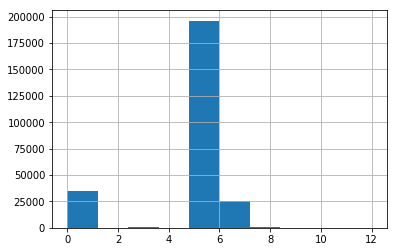

In [17]:
for_predict_df_prod['predict_random_forest_f1_0_84'].hist()

In [58]:
for_predict_df_prod['predict_random_forest_f1_0_80'].hist()

In [59]:
for_predict_df_prod['predict_catboost_f1_0_77'].hist()

In [143]:
rmse = mean_squared_error(for_predict_df_prod['predict_random_forest_f1_0_84'], for_predict_df_prod['predict_catboost_f1_0_77'])
print('rmse ' + str(rmse))

KeyError: 'predict_catboost_f1_0_77'